In [2]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.models.gaussian_process import *

from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening BSCCM
Opened BSCCM


## Evaluating the fit of stationary vs nonstationary gaussian processes
Fitting a stationary model helps avoid small eigenvlues when cov mat is computed with a small number of patches

In [8]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_patches_to_use = onp.array([10, 33, 100, 333, 1000, 3333, 10000])
# num_patches_to_use = onp.array([2, 8, 32, 128, 512, 2048, 8192])
num_patches = num_patches_to_use.max()
num_test_set_patches = 4000
num_images = num_patches
num_bootstraps = 10
# channel = 'DPC_Right'
channel = 'LED119'
eigenvalue_floor = 1e-3

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_set_images = all_images[num_images:]
patches = extract_patches(images, patch_size, num_patches=num_patches)
test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches)

cov_mats = {}
non_stationary_means = {}
stationary_means = {}
cov_mats_stationary = {}
cov_mats_stationary_optimized = {}
for n_patches in tqdm(num_patches_to_use):
    cov_mats[n_patches] = []
    non_stationary_means[n_patches] = []
    stationary_means[n_patches] = []
    cov_mats_stationary[n_patches] = []
    cov_mats_stationary_optimized[n_patches] = []
    for i in range(num_bootstraps):
        patch_indices = onp.random.choice(np.arange(patches.shape[0]), n_patches, replace=False)
        bootstrapped_patches = patches[patch_indices]
        cov_mat = make_positive_definite(estimate_full_cov_mat(bootstrapped_patches), eigenvalue_floor=eigenvalue_floor)
        non_stationary_mean = np.mean(bootstrapped_patches, axis=0).flatten()
        stationary_mean = non_stationary_mean * np.ones_like(non_stationary_mean)
        gp = StationaryGaussianProcess(bootstrapped_patches)
        cov_mat_stationary = gp.get_cov_mat()
        gp.fit(bootstrapped_patches, num_val_samples=max(4, min(200, int(0.1 * bootstrapped_patches.shape[0]))))
        cov_mat_stationary_optimized = gp.get_cov_mat()

        cov_mats[n_patches].append(cov_mat)
        non_stationary_means[n_patches].append(non_stationary_mean)
        stationary_means[n_patches].append(stationary_mean)
        cov_mats_stationary[n_patches].append(cov_mat_stationary)
        cov_mats_stationary_optimized[n_patches].append(cov_mat_stationary_optimized)


Computing loss: 1it [00:00,  2.47it/s]


Initial validation NLL: 146550.13


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]
Computing loss: 1it [00:00, 58.69it/s]


Epoch 1: validation NLL: 106633.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]
Computing loss: 1it [00:00, 61.77it/s]


Epoch 2: validation NLL: 42547.08


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.68it/s]
Computing loss: 1it [00:00, 65.43it/s]


Epoch 3: validation NLL: 43928.99


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.55it/s]
Computing loss: 1it [00:00, 65.34it/s]


Epoch 4: validation NLL: 40955.49


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s]
Computing loss: 1it [00:00, 64.73it/s]


Epoch 5: validation NLL: 13.81


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.15it/s]
Computing loss: 1it [00:00, 51.96it/s]


Epoch 6: validation NLL: 5.12


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
Computing loss: 1it [00:00, 51.98it/s]


Epoch 7: validation NLL: 4.93


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]
Computing loss: 1it [00:00, 59.53it/s]


Epoch 8: validation NLL: 4.87


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.02it/s]
Computing loss: 1it [00:00, 67.64it/s]


Epoch 9: validation NLL: 4.85


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.82it/s]
Computing loss: 1it [00:00, 64.82it/s]


Epoch 10: validation NLL: 4.84


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.21it/s]
Computing loss: 1it [00:00, 58.94it/s]


Epoch 11: validation NLL: 4.83


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.20it/s]
Computing loss: 1it [00:00, 53.48it/s]


Epoch 12: validation NLL: 4.83


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
Computing loss: 1it [00:00, 62.21it/s]


Epoch 13: validation NLL: 4.83


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.19it/s]
Computing loss: 1it [00:00, 64.11it/s]


Epoch 14: validation NLL: 4.83


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 43.36it/s]
Computing loss: 1it [00:00, 66.19it/s]


Epoch 15: validation NLL: 4.83


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 43.74it/s]
Computing loss: 1it [00:00, 68.65it/s]


Epoch 16: validation NLL: 4.83


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 46.92it/s]
Computing loss: 1it [00:00, 71.31it/s]


Epoch 17: validation NLL: 4.83


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 45.59it/s]
Computing loss: 1it [00:00, 50.67it/s]


Epoch 18: validation NLL: 4.83


Computing loss: 1it [00:00,  1.48it/s]


Initial validation NLL: 49831.35


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]
Computing loss: 1it [00:00, 55.65it/s]


Epoch 1: validation NLL: 43955.05


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]
Computing loss: 1it [00:00, 61.45it/s]


Epoch 2: validation NLL: 23092.22


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.21it/s]
Computing loss: 1it [00:00, 55.74it/s]


Epoch 3: validation NLL: 6.70


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.28it/s]
Computing loss: 1it [00:00, 71.11it/s]


Epoch 4: validation NLL: 5.03


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.33it/s]
Computing loss: 1it [00:00, 75.57it/s]


Epoch 5: validation NLL: 4.89


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.99it/s]
Computing loss: 1it [00:00, 63.24it/s]


Epoch 6: validation NLL: 4.86


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]
Computing loss: 1it [00:00, 64.04it/s]


Epoch 7: validation NLL: 4.83


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.04it/s]
Computing loss: 1it [00:00, 63.83it/s]


Epoch 8: validation NLL: 4.83


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s]
Computing loss: 1it [00:00, 65.83it/s]


Epoch 9: validation NLL: 4.82


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]
Computing loss: 1it [00:00, 56.38it/s]


Epoch 10: validation NLL: 4.82


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]
Computing loss: 1it [00:00, 66.14it/s]


Epoch 11: validation NLL: 4.82


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]
Computing loss: 1it [00:00,  3.17it/s]


Epoch 12: validation NLL: 4.82


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s]
Computing loss: 1it [00:00, 66.59it/s]


Epoch 13: validation NLL: 4.82


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.12it/s]
Computing loss: 1it [00:00, 60.96it/s]


Epoch 14: validation NLL: 4.82


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.40it/s]
Computing loss: 1it [00:00, 62.68it/s]


Epoch 15: validation NLL: 4.83


Computing loss: 1it [00:00,  1.75it/s]


Initial validation NLL: 29644.74


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]
Computing loss: 1it [00:00, 50.32it/s]


Epoch 1: validation NLL: 28963.94


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.01it/s]
Computing loss: 1it [00:00, 71.79it/s]


Epoch 2: validation NLL: 28685.58


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.73it/s]
Computing loss: 1it [00:00, 50.56it/s]


Epoch 3: validation NLL: 25475.88


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.07it/s]
Computing loss: 1it [00:00, 48.71it/s]


Epoch 4: validation NLL: 25082.82


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.37it/s]
Computing loss: 1it [00:00, 64.38it/s]


Epoch 5: validation NLL: 24461.99


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]
Computing loss: 1it [00:00, 63.75it/s]


Epoch 6: validation NLL: 4.87


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.51it/s]
Computing loss: 1it [00:00, 48.81it/s]


Epoch 7: validation NLL: 4.80


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.73it/s]
Computing loss: 1it [00:00, 52.25it/s]


Epoch 8: validation NLL: 4.80


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.55it/s]
Computing loss: 1it [00:00, 68.96it/s]


Epoch 9: validation NLL: 4.79


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.81it/s]
Computing loss: 1it [00:00, 56.74it/s]


Epoch 10: validation NLL: 4.79


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s]
Computing loss: 1it [00:00, 57.49it/s]


Epoch 11: validation NLL: 4.79


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
Computing loss: 1it [00:00, 52.68it/s]


Epoch 12: validation NLL: 4.80


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.16it/s]
Computing loss: 1it [00:00, 63.97it/s]


Epoch 13: validation NLL: 4.80


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 46.08it/s]
Computing loss: 1it [00:00, 55.69it/s]


Epoch 14: validation NLL: 4.80


Computing loss: 1it [00:00,  1.59it/s]


Initial validation NLL: 57099.35


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]
Computing loss: 1it [00:00, 44.25it/s]


Epoch 1: validation NLL: 27888.18


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
Computing loss: 1it [00:00, 61.63it/s]


Epoch 2: validation NLL: 19989.32


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.68it/s]
Computing loss: 1it [00:00, 69.92it/s]


Epoch 3: validation NLL: 12352.68


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s]
Computing loss: 1it [00:00, 67.26it/s]


Epoch 4: validation NLL: 4.86


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 41.69it/s]
Computing loss: 1it [00:00, 61.03it/s]


Epoch 5: validation NLL: 4.80


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]
Computing loss: 1it [00:00, 65.12it/s]


Epoch 6: validation NLL: 4.79


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 42.86it/s]
Computing loss: 1it [00:00, 64.70it/s]


Epoch 7: validation NLL: 4.80


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.28it/s]
Computing loss: 1it [00:00, 65.44it/s]


Epoch 8: validation NLL: 4.81


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s]
Computing loss: 1it [00:00, 57.08it/s]


Epoch 9: validation NLL: 4.81


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.22it/s]
Computing loss: 1it [00:00, 73.54it/s]


Epoch 10: validation NLL: 4.82


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.87it/s]
Computing loss: 1it [00:00, 62.95it/s]


Epoch 11: validation NLL: 4.83


Computing loss: 1it [00:00,  1.58it/s]


Initial validation NLL: 30930.67


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]
Computing loss: 1it [00:00, 52.89it/s]


Epoch 1: validation NLL: 21573.16


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.88it/s]
Computing loss: 1it [00:00, 63.77it/s]


Epoch 2: validation NLL: 20046.96


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.21it/s]
Computing loss: 1it [00:00, 65.83it/s]


Epoch 3: validation NLL: 18976.48


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 42.66it/s]
Computing loss: 1it [00:00, 67.52it/s]


Epoch 4: validation NLL: 19031.78


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.19it/s]
Computing loss: 1it [00:00, 64.10it/s]


Epoch 5: validation NLL: 19013.14


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 42.68it/s]
Computing loss: 1it [00:00, 63.40it/s]


Epoch 6: validation NLL: 25.33


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]
Computing loss: 1it [00:00, 52.13it/s]


Epoch 7: validation NLL: 4.79


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]
Computing loss: 1it [00:00, 64.57it/s]


Epoch 8: validation NLL: 4.74


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
Computing loss: 1it [00:00, 67.17it/s]


Epoch 9: validation NLL: 4.73


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.99it/s]
Computing loss: 1it [00:00, 58.53it/s]


Epoch 10: validation NLL: 4.74


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.68it/s]
Computing loss: 1it [00:00, 66.81it/s]


Epoch 11: validation NLL: 4.75


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
Computing loss: 1it [00:00, 68.24it/s]


Epoch 12: validation NLL: 4.75


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]
Computing loss: 1it [00:00, 64.94it/s]


Epoch 13: validation NLL: 4.76


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.04it/s]
Computing loss: 1it [00:00, 56.66it/s]


Epoch 14: validation NLL: 4.76


Computing loss: 1it [00:00,  2.65it/s]


Initial validation NLL: 79260.13


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]
Computing loss: 1it [00:00, 53.40it/s]


Epoch 1: validation NLL: 60972.98


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
Computing loss: 1it [00:00, 70.19it/s]


Epoch 2: validation NLL: 52567.21


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.85it/s]
Computing loss: 1it [00:00, 58.08it/s]


Epoch 3: validation NLL: 43208.35


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.25it/s]
Computing loss: 1it [00:00, 73.34it/s]


Epoch 4: validation NLL: 42464.42


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.19it/s]
Computing loss: 1it [00:00, 63.27it/s]


Epoch 5: validation NLL: 41595.61


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.81it/s]
Computing loss: 1it [00:00, 52.76it/s]


Epoch 6: validation NLL: 5.27


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.67it/s]
Computing loss: 1it [00:00, 58.39it/s]


Epoch 7: validation NLL: 4.95


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]
Computing loss: 1it [00:00, 63.18it/s]


Epoch 8: validation NLL: 4.86


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]
Computing loss: 1it [00:00, 60.61it/s]


Epoch 9: validation NLL: 4.82


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]
Computing loss: 1it [00:00, 72.14it/s]


Epoch 10: validation NLL: 4.79


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]
Computing loss: 1it [00:00, 75.03it/s]


Epoch 11: validation NLL: 4.78


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.66it/s]
Computing loss: 1it [00:00, 62.65it/s]


Epoch 12: validation NLL: 4.77


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.82it/s]
Computing loss: 1it [00:00, 69.63it/s]


Epoch 13: validation NLL: 4.77


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
Computing loss: 1it [00:00, 75.11it/s]


Epoch 14: validation NLL: 4.77


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 46.15it/s]
Computing loss: 1it [00:00, 58.15it/s]


Epoch 15: validation NLL: 4.77


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 46.92it/s]
Computing loss: 1it [00:00, 51.13it/s]


Epoch 16: validation NLL: 4.77


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 46.37it/s]
Computing loss: 1it [00:00, 49.74it/s]


Epoch 17: validation NLL: 4.77


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 46.05it/s]
Computing loss: 1it [00:00, 64.14it/s]


Epoch 18: validation NLL: 4.78


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]
Computing loss: 1it [00:00, 55.30it/s]


Epoch 19: validation NLL: 4.78


Computing loss: 1it [00:00,  1.62it/s]


Initial validation NLL: 189884.77


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]
Computing loss: 1it [00:00, 65.87it/s]


Epoch 1: validation NLL: 132290.85


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s]
Computing loss: 1it [00:00, 55.52it/s]


Epoch 2: validation NLL: 88161.87


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.68it/s]
Computing loss: 1it [00:00, 62.88it/s]


Epoch 3: validation NLL: 28825.51


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 42.63it/s]
Computing loss: 1it [00:00, 63.85it/s]


Epoch 4: validation NLL: 28275.14


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s]
Computing loss: 1it [00:00, 67.72it/s]


Epoch 5: validation NLL: 27779.94


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.99it/s]
Computing loss: 1it [00:00, 63.91it/s]


Epoch 6: validation NLL: 6.15


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.31it/s]
Computing loss: 1it [00:00, 59.94it/s]


Epoch 7: validation NLL: 5.06


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.72it/s]
Computing loss: 1it [00:00, 64.63it/s]


Epoch 8: validation NLL: 4.97


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.81it/s]
Computing loss: 1it [00:00, 63.26it/s]


Epoch 9: validation NLL: 4.94


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.63it/s]
Computing loss: 1it [00:00, 55.98it/s]


Epoch 10: validation NLL: 4.92


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s]
Computing loss: 1it [00:00, 62.45it/s]


Epoch 11: validation NLL: 4.91


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]
Computing loss: 1it [00:00,  3.19it/s]


Epoch 12: validation NLL: 4.91


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.20it/s]
Computing loss: 1it [00:00, 62.35it/s]


Epoch 13: validation NLL: 4.91


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]
Computing loss: 1it [00:00, 62.75it/s]


Epoch 14: validation NLL: 4.91


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 44.81it/s]
Computing loss: 1it [00:00, 65.94it/s]


Epoch 15: validation NLL: 4.91


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s]
Computing loss: 1it [00:00, 61.19it/s]


Epoch 16: validation NLL: 4.91


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 45.10it/s]
Computing loss: 1it [00:00, 61.12it/s]


Epoch 17: validation NLL: 4.91


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 46.00it/s]
Computing loss: 1it [00:00, 66.52it/s]


Epoch 18: validation NLL: 4.91


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 46.08it/s]
Computing loss: 1it [00:00, 61.77it/s]


Epoch 19: validation NLL: 4.91


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 46.80it/s]
Computing loss: 1it [00:00, 61.47it/s]


Epoch 20: validation NLL: 4.91


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 45.90it/s]
Computing loss: 1it [00:00, 57.48it/s]


Epoch 21: validation NLL: 4.91


Computing loss: 1it [00:00,  1.49it/s]


Initial validation NLL: 44625.03


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]
Computing loss: 1it [00:00, 54.72it/s]


Epoch 1: validation NLL: 24217.14


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]
Computing loss: 1it [00:00, 62.41it/s]


Epoch 2: validation NLL: 10256.76


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.73it/s]
Computing loss: 1it [00:00, 62.96it/s]


Epoch 3: validation NLL: 9124.57


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.48it/s]
Computing loss: 1it [00:00, 48.47it/s]


Epoch 4: validation NLL: 9558.76


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]
Computing loss: 1it [00:00, 68.81it/s]


Epoch 5: validation NLL: 9036.91


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.94it/s]
Computing loss: 1it [00:00, 65.26it/s]


Epoch 6: validation NLL: 4.82


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.09it/s]
Computing loss: 1it [00:00, 62.57it/s]


Epoch 7: validation NLL: 4.62


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.20it/s]
Computing loss: 1it [00:00, 59.81it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.89it/s]
Computing loss: 1it [00:00, 74.76it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]
Computing loss: 1it [00:00, 58.86it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.40it/s]
Computing loss: 1it [00:00, 51.59it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]
Computing loss: 1it [00:00,  3.21it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]
Computing loss: 1it [00:00, 60.72it/s]


Epoch 13: validation NLL: 4.62


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 46.55it/s]
Computing loss: 1it [00:00, 67.34it/s]


Epoch 14: validation NLL: 4.62


Computing loss: 1it [00:00,  2.38it/s]


Initial validation NLL: 43107.08


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]
Computing loss: 1it [00:00, 57.20it/s]


Epoch 1: validation NLL: 29171.94


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
Computing loss: 1it [00:00, 65.02it/s]


Epoch 2: validation NLL: 19351.09


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.10it/s]
Computing loss: 1it [00:00, 55.87it/s]


Epoch 3: validation NLL: 3310.20


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.08it/s]
Computing loss: 1it [00:00, 64.17it/s]


Epoch 4: validation NLL: 3348.76


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 42.42it/s]
Computing loss: 1it [00:00, 66.55it/s]


Epoch 5: validation NLL: 4.76


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.19it/s]
Computing loss: 1it [00:00, 75.44it/s]


Epoch 6: validation NLL: 4.68


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 42.42it/s]
Computing loss: 1it [00:00, 65.61it/s]


Epoch 7: validation NLL: 4.67


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 42.65it/s]
Computing loss: 1it [00:00, 55.80it/s]


Epoch 8: validation NLL: 4.67


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.23it/s]
Computing loss: 1it [00:00, 76.19it/s]


Epoch 9: validation NLL: 4.68


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]
Computing loss: 1it [00:00, 66.18it/s]


Epoch 10: validation NLL: 4.68


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]
Computing loss: 1it [00:00, 57.56it/s]


Epoch 11: validation NLL: 4.69


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s]
Computing loss: 1it [00:00, 75.56it/s]


Epoch 12: validation NLL: 4.69


Computing loss: 1it [00:00,  1.66it/s]


Initial validation NLL: 59555.42


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]
Computing loss: 1it [00:00, 45.61it/s]


Epoch 1: validation NLL: 35480.29


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
Computing loss: 1it [00:00, 49.85it/s]


Epoch 2: validation NLL: 18678.20


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.92it/s]
Computing loss: 1it [00:00, 49.56it/s]


Epoch 3: validation NLL: 9280.69


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]
Computing loss: 1it [00:00, 52.32it/s]


Epoch 4: validation NLL: 9206.34


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.07it/s]
Computing loss: 1it [00:00, 61.50it/s]


Epoch 5: validation NLL: 9149.65


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]
Computing loss: 1it [00:00, 72.01it/s]


Epoch 6: validation NLL: 6.41


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.06it/s]
Computing loss: 1it [00:00, 55.08it/s]


Epoch 7: validation NLL: 4.77


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]
Computing loss: 1it [00:00, 64.85it/s]


Epoch 8: validation NLL: 4.76


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.64it/s]
Computing loss: 1it [00:00, 72.40it/s]


Epoch 9: validation NLL: 4.77


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s]
Computing loss: 1it [00:00, 62.73it/s]


Epoch 10: validation NLL: 4.77


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]
Computing loss: 1it [00:00, 62.20it/s]


Epoch 11: validation NLL: 4.78


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.07it/s]
Computing loss: 1it [00:00, 56.27it/s]


Epoch 12: validation NLL: 4.79


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.95it/s]
Computing loss: 1it [00:00, 60.67it/s]
 14%|█▍        | 1/7 [01:01<06:11, 61.88s/it]

Epoch 13: validation NLL: 4.80


Computing loss: 1it [00:00,  2.40it/s]


Initial validation NLL: 16400.82


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]
Computing loss: 1it [00:00, 50.88it/s]


Epoch 1: validation NLL: 5062.99


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
Computing loss: 1it [00:00, 64.12it/s]


Epoch 2: validation NLL: 569.46


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.74it/s]
Computing loss: 1it [00:00, 72.75it/s]


Epoch 3: validation NLL: 4.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.16it/s]
Computing loss: 1it [00:00, 62.46it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.52it/s]
Computing loss: 1it [00:00, 61.83it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 41.56it/s]
Computing loss: 1it [00:00, 63.88it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.73it/s]
Computing loss: 1it [00:00, 67.36it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.84it/s]
Computing loss: 1it [00:00, 68.01it/s]


Epoch 8: validation NLL: 4.58


Computing loss: 1it [00:00,  1.66it/s]


Initial validation NLL: 29909.31


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]
Computing loss: 1it [00:00, 56.02it/s]


Epoch 1: validation NLL: 17461.90


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]
Computing loss: 1it [00:00, 73.43it/s]


Epoch 2: validation NLL: 4.83


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s]
Computing loss: 1it [00:00, 62.86it/s]


Epoch 3: validation NLL: 4.76


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.23it/s]
Computing loss: 1it [00:00, 60.51it/s]


Epoch 4: validation NLL: 4.75


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]
Computing loss: 1it [00:00, 64.50it/s]


Epoch 5: validation NLL: 4.76


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.67it/s]
Computing loss: 1it [00:00, 56.00it/s]


Epoch 6: validation NLL: 4.76


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]
Computing loss: 1it [00:00, 58.98it/s]


Epoch 7: validation NLL: 4.77


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.98it/s]
Computing loss: 1it [00:00, 64.07it/s]


Epoch 8: validation NLL: 4.77


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.29it/s]
Computing loss: 1it [00:00, 68.35it/s]


Epoch 9: validation NLL: 4.78


Computing loss: 1it [00:00,  2.21it/s]


Initial validation NLL: 34420.18


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]
Computing loss: 1it [00:00, 63.95it/s]


Epoch 1: validation NLL: 25537.45


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]
Computing loss: 1it [00:00, 64.93it/s]


Epoch 2: validation NLL: 24462.64


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]
Computing loss: 1it [00:00, 61.66it/s]


Epoch 3: validation NLL: 4.88


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.02it/s]
Computing loss: 1it [00:00, 57.87it/s]


Epoch 4: validation NLL: 4.71


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 42.61it/s]
Computing loss: 1it [00:00, 65.48it/s]


Epoch 5: validation NLL: 4.70


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s]
Computing loss: 1it [00:00, 61.91it/s]


Epoch 6: validation NLL: 4.70


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.94it/s]
Computing loss: 1it [00:00, 65.50it/s]


Epoch 7: validation NLL: 4.69


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.46it/s]
Computing loss: 1it [00:00, 67.25it/s]


Epoch 8: validation NLL: 4.69


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.35it/s]
Computing loss: 1it [00:00, 56.60it/s]


Epoch 9: validation NLL: 4.69


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.91it/s]
Computing loss: 1it [00:00, 63.96it/s]


Epoch 10: validation NLL: 4.69


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.80it/s]
Computing loss: 1it [00:00, 56.40it/s]


Epoch 11: validation NLL: 4.68


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]
Computing loss: 1it [00:00, 74.45it/s]


Epoch 12: validation NLL: 4.69


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
Computing loss: 1it [00:00, 66.41it/s]


Epoch 13: validation NLL: 4.69


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]
Computing loss: 1it [00:00, 66.46it/s]


Epoch 14: validation NLL: 4.69


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 42.25it/s]
Computing loss: 1it [00:00, 57.35it/s]


Epoch 15: validation NLL: 4.69


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 46.30it/s]
Computing loss: 1it [00:00, 66.97it/s]


Epoch 16: validation NLL: 4.69


Computing loss: 1it [00:00,  2.58it/s]


Initial validation NLL: 8219.62


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]
Computing loss: 1it [00:00, 55.57it/s]


Epoch 1: validation NLL: 1280.85


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 36.41it/s]
Computing loss: 1it [00:00, 64.82it/s]


Epoch 2: validation NLL: 4.54


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s]
Computing loss: 1it [00:00, 67.34it/s]


Epoch 3: validation NLL: 4.52


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s]
Computing loss: 1it [00:00, 59.37it/s]


Epoch 4: validation NLL: 4.52


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 42.34it/s]
Computing loss: 1it [00:00, 65.62it/s]


Epoch 5: validation NLL: 4.53


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]
Computing loss: 1it [00:00, 67.63it/s]


Epoch 6: validation NLL: 4.53


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.68it/s]
Computing loss: 1it [00:00, 52.75it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.89it/s]
Computing loss: 1it [00:00, 61.94it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.76it/s]
Computing loss: 1it [00:00, 72.08it/s]


Epoch 9: validation NLL: 4.55


Computing loss: 1it [00:00,  1.98it/s]


Initial validation NLL: 23474.65


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]
Computing loss: 1it [00:00, 51.33it/s]


Epoch 1: validation NLL: 7207.64


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.95it/s]
Computing loss: 1it [00:00, 65.17it/s]


Epoch 2: validation NLL: 4.71


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 41.71it/s]
Computing loss: 1it [00:00, 57.93it/s]


Epoch 3: validation NLL: 4.62


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.12it/s]
Computing loss: 1it [00:00, 45.99it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.85it/s]
Computing loss: 1it [00:00, 77.13it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.71it/s]
Computing loss: 1it [00:00, 62.77it/s]


Epoch 6: validation NLL: 4.63


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.33it/s]
Computing loss: 1it [00:00, 73.45it/s]


Epoch 7: validation NLL: 4.64


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.49it/s]
Computing loss: 1it [00:00, 75.09it/s]


Epoch 8: validation NLL: 4.65


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.09it/s]
Computing loss: 1it [00:00, 63.61it/s]

Epoch 9: validation NLL: 4.65



Computing loss: 1it [00:00,  1.50it/s]


Initial validation NLL: 98036.33


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]
Computing loss: 1it [00:00, 51.40it/s]


Epoch 1: validation NLL: 44021.11


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]
Computing loss: 1it [00:00, 69.82it/s]


Epoch 2: validation NLL: 5908.58


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.79it/s]
Computing loss: 1it [00:00, 61.12it/s]


Epoch 3: validation NLL: 4.75


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 41.75it/s]
Computing loss: 1it [00:00, 61.50it/s]


Epoch 4: validation NLL: 4.70


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 42.10it/s]
Computing loss: 1it [00:00, 56.27it/s]


Epoch 5: validation NLL: 4.69


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]
Computing loss: 1it [00:00, 60.40it/s]


Epoch 6: validation NLL: 4.70


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.81it/s]
Computing loss: 1it [00:00, 63.99it/s]


Epoch 7: validation NLL: 4.70


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.13it/s]
Computing loss: 1it [00:00, 73.20it/s]


Epoch 8: validation NLL: 4.71


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.00it/s]
Computing loss: 1it [00:00, 70.13it/s]


Epoch 9: validation NLL: 4.71


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.88it/s]
Computing loss: 1it [00:00, 57.36it/s]


Epoch 10: validation NLL: 4.72


Computing loss: 1it [00:00,  2.52it/s]


Initial validation NLL: 10968.50


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]
Computing loss: 1it [00:00, 59.36it/s]


Epoch 1: validation NLL: 3889.47


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.95it/s]
Computing loss: 1it [00:00, 57.84it/s]


Epoch 2: validation NLL: 896.65


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.52it/s]
Computing loss: 1it [00:00, 60.50it/s]


Epoch 3: validation NLL: 4.47


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.42it/s]
Computing loss: 1it [00:00, 60.94it/s]


Epoch 4: validation NLL: 4.48


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.10it/s]
Computing loss: 1it [00:00, 67.64it/s]


Epoch 5: validation NLL: 4.48


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.57it/s]
Computing loss: 1it [00:00, 53.74it/s]


Epoch 6: validation NLL: 4.50


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.05it/s]
Computing loss: 1it [00:00, 62.80it/s]


Epoch 7: validation NLL: 4.50


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 43.84it/s]
Computing loss: 1it [00:00, 57.18it/s]


Epoch 8: validation NLL: 4.51


Computing loss: 1it [00:00,  2.04it/s]


Initial validation NLL: 15732.13


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]
Computing loss: 1it [00:00, 52.15it/s]


Epoch 1: validation NLL: 11411.87


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]
Computing loss: 1it [00:00, 58.86it/s]


Epoch 2: validation NLL: 4.76


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.16it/s]
Computing loss: 1it [00:00, 69.57it/s]


Epoch 3: validation NLL: 4.69


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.43it/s]
Computing loss: 1it [00:00, 66.51it/s]


Epoch 4: validation NLL: 4.67


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
Computing loss: 1it [00:00, 67.42it/s]


Epoch 5: validation NLL: 4.67


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s]
Computing loss: 1it [00:00, 71.47it/s]


Epoch 6: validation NLL: 4.68


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]
Computing loss: 1it [00:00, 75.63it/s]


Epoch 7: validation NLL: 4.68


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.59it/s]
Computing loss: 1it [00:00, 49.98it/s]


Epoch 8: validation NLL: 4.69


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.80it/s]
Computing loss: 1it [00:00, 58.93it/s]


Epoch 9: validation NLL: 4.69


Computing loss: 1it [00:00,  2.01it/s]


Initial validation NLL: 22438.44


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]
Computing loss: 1it [00:00, 59.01it/s]


Epoch 1: validation NLL: 3800.54


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]
Computing loss: 1it [00:00, 71.71it/s]


Epoch 2: validation NLL: 384.01


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.92it/s]
Computing loss: 1it [00:00, 72.80it/s]


Epoch 3: validation NLL: 4.78


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 42.79it/s]
Computing loss: 1it [00:00, 48.56it/s]


Epoch 4: validation NLL: 4.79


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.79it/s]
Computing loss: 1it [00:00, 74.51it/s]


Epoch 5: validation NLL: 4.78


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s]
Computing loss: 1it [00:00, 64.00it/s]


Epoch 6: validation NLL: 4.78


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.20it/s]
Computing loss: 1it [00:00, 58.80it/s]


Epoch 7: validation NLL: 4.78


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.49it/s]
Computing loss: 1it [00:00, 64.34it/s]


Epoch 8: validation NLL: 4.79


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.43it/s]
Computing loss: 1it [00:00, 66.48it/s]


Epoch 9: validation NLL: 4.79


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.13it/s]
Computing loss: 1it [00:00, 63.54it/s]


Epoch 10: validation NLL: 4.80


Computing loss: 1it [00:00,  1.59it/s]


Initial validation NLL: 15987.94


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]
Computing loss: 1it [00:00,  3.12it/s]


Epoch 1: validation NLL: 6437.30


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 40.67it/s]
Computing loss: 1it [00:00, 57.10it/s]


Epoch 2: validation NLL: 508.97


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.79it/s]
Computing loss: 1it [00:00, 50.94it/s]


Epoch 3: validation NLL: 4.65


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s]
Computing loss: 1it [00:00, 54.47it/s]


Epoch 4: validation NLL: 4.63


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.41it/s]
Computing loss: 1it [00:00, 55.96it/s]


Epoch 5: validation NLL: 4.63


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.39it/s]
Computing loss: 1it [00:00, 60.95it/s]


Epoch 6: validation NLL: 4.64


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s]
Computing loss: 1it [00:00, 64.21it/s]


Epoch 7: validation NLL: 4.64


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]
Computing loss: 1it [00:00, 56.54it/s]


Epoch 8: validation NLL: 4.64


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.21it/s]
Computing loss: 1it [00:00, 62.87it/s]


Epoch 9: validation NLL: 4.65


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.53it/s]
Computing loss: 1it [00:00, 54.67it/s]
 29%|██▊       | 2/7 [01:59<04:56, 59.36s/it]

Epoch 10: validation NLL: 4.66


Computing loss: 1it [00:00,  1.23it/s]


Initial validation NLL: 4.65


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]
Computing loss: 1it [00:00,  3.09it/s]


Epoch 1: validation NLL: 4.65


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s]
Computing loss: 1it [00:00, 58.84it/s]


Epoch 2: validation NLL: 4.65


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.26it/s]
Computing loss: 1it [00:00, 51.87it/s]


Epoch 3: validation NLL: 4.65


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 42.74it/s]
Computing loss: 1it [00:00, 53.40it/s]


Epoch 4: validation NLL: 4.65


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]
Computing loss: 1it [00:00, 68.93it/s]


Epoch 5: validation NLL: 4.65


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.58it/s]
Computing loss: 1it [00:00, 60.53it/s]


Epoch 6: validation NLL: 4.65


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.60it/s]
Computing loss: 1it [00:00, 46.10it/s]


Epoch 7: validation NLL: 4.65


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.63it/s]
Computing loss: 1it [00:00, 51.16it/s]


Epoch 8: validation NLL: 4.65


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]
Computing loss: 1it [00:00, 62.59it/s]


Epoch 9: validation NLL: 4.65


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s]
Computing loss: 1it [00:00, 60.13it/s]


Epoch 10: validation NLL: 4.65


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s]
Computing loss: 1it [00:00, 63.37it/s]


Epoch 11: validation NLL: 4.65


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.53it/s]
Computing loss: 1it [00:00, 47.22it/s]


Epoch 12: validation NLL: 4.65


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
Computing loss: 1it [00:00, 60.73it/s]


Epoch 13: validation NLL: 4.65


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.23it/s]
Computing loss: 1it [00:00, 55.74it/s]


Epoch 14: validation NLL: 4.65


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
Computing loss: 1it [00:00, 58.18it/s]


Epoch 15: validation NLL: 4.65


Computing loss: 1it [00:00,  1.18it/s]


Initial validation NLL: 29380.46


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]
Computing loss: 1it [00:00, 48.24it/s]


Epoch 1: validation NLL: 5397.15


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.95it/s]
Computing loss: 1it [00:00, 58.35it/s]


Epoch 2: validation NLL: 4.70


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.57it/s]
Computing loss: 1it [00:00, 57.18it/s]


Epoch 3: validation NLL: 4.67


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]
Computing loss: 1it [00:00, 58.18it/s]


Epoch 4: validation NLL: 4.67


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.93it/s]
Computing loss: 1it [00:00, 62.01it/s]


Epoch 5: validation NLL: 4.66


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.67it/s]
Computing loss: 1it [00:00, 65.18it/s]


Epoch 6: validation NLL: 4.67


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.07it/s]
Computing loss: 1it [00:00, 52.16it/s]


Epoch 7: validation NLL: 4.66


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.01it/s]
Computing loss: 1it [00:00, 66.73it/s]


Epoch 8: validation NLL: 4.67


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.32it/s]
Computing loss: 1it [00:00, 58.48it/s]


Epoch 9: validation NLL: 4.67


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.23it/s]
Computing loss: 1it [00:00, 61.21it/s]


Epoch 10: validation NLL: 4.67


Computing loss: 1it [00:00,  1.19it/s]


Initial validation NLL: 7612.14


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]
Computing loss: 1it [00:00, 55.70it/s]


Epoch 1: validation NLL: 439.97


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
Computing loss: 1it [00:00, 55.55it/s]


Epoch 2: validation NLL: 4.56


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s]
Computing loss: 1it [00:00, 57.27it/s]


Epoch 3: validation NLL: 4.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.65it/s]
Computing loss: 1it [00:00, 56.69it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s]
Computing loss: 1it [00:00, 53.18it/s]


Epoch 5: validation NLL: 4.55


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.56it/s]
Computing loss: 1it [00:00, 52.90it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.19it/s]
Computing loss: 1it [00:00, 59.30it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 43.13it/s]
Computing loss: 1it [00:00, 57.77it/s]


Epoch 8: validation NLL: 4.56


Computing loss: 1it [00:00,  1.46it/s]


Initial validation NLL: 8817.81


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]
Computing loss: 1it [00:00, 48.38it/s]


Epoch 1: validation NLL: 2313.03


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]
Computing loss: 1it [00:00, 45.92it/s]


Epoch 2: validation NLL: 4.52


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.12it/s]
Computing loss: 1it [00:00, 58.00it/s]


Epoch 3: validation NLL: 4.50


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.72it/s]
Computing loss: 1it [00:00, 57.16it/s]


Epoch 4: validation NLL: 4.51


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.38it/s]
Computing loss: 1it [00:00, 55.32it/s]


Epoch 5: validation NLL: 4.51


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.42it/s]
Computing loss: 1it [00:00, 46.16it/s]


Epoch 6: validation NLL: 4.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.48it/s]
Computing loss: 1it [00:00, 56.04it/s]


Epoch 7: validation NLL: 4.52


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.74it/s]
Computing loss: 1it [00:00, 61.94it/s]


Epoch 8: validation NLL: 4.53


Computing loss: 1it [00:01,  1.13s/it]


Initial validation NLL: 9317.08


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]
Computing loss: 1it [00:00, 51.03it/s]


Epoch 1: validation NLL: 2118.43


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.62it/s]
Computing loss: 1it [00:00, 50.62it/s]


Epoch 2: validation NLL: 4.60


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.13it/s]
Computing loss: 1it [00:00, 61.43it/s]


Epoch 3: validation NLL: 4.58


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 42.91it/s]
Computing loss: 1it [00:00, 59.06it/s]


Epoch 4: validation NLL: 4.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 42.14it/s]
Computing loss: 1it [00:00, 54.70it/s]


Epoch 5: validation NLL: 4.58


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.14it/s]
Computing loss: 1it [00:00, 59.73it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.52it/s]
Computing loss: 1it [00:00, 51.59it/s]


Epoch 7: validation NLL: 4.59


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s]
Computing loss: 1it [00:00, 63.74it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.14it/s]
Computing loss: 1it [00:00, 60.64it/s]


Epoch 9: validation NLL: 4.59


Computing loss: 1it [00:00,  1.02it/s]


Initial validation NLL: 3678.62


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]
Computing loss: 1it [00:00, 51.37it/s]


Epoch 1: validation NLL: 2277.78


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]
Computing loss: 1it [00:00, 47.18it/s]


Epoch 2: validation NLL: 4.62


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.67it/s]
Computing loss: 1it [00:00, 60.84it/s]


Epoch 3: validation NLL: 4.59


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.24it/s]
Computing loss: 1it [00:00, 63.68it/s]


Epoch 4: validation NLL: 4.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.04it/s]
Computing loss: 1it [00:00, 61.42it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.70it/s]
Computing loss: 1it [00:00, 48.23it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]
Computing loss: 1it [00:00, 66.17it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.61it/s]
Computing loss: 1it [00:00, 54.71it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s]
Computing loss: 1it [00:00, 51.08it/s]


Epoch 9: validation NLL: 4.57


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]
Computing loss: 1it [00:00, 59.17it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]
Computing loss: 1it [00:00, 53.54it/s]


Epoch 11: validation NLL: 4.57


Computing loss: 1it [00:00,  1.17it/s]


Initial validation NLL: 765.03


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]
Computing loss: 1it [00:00, 46.59it/s]


Epoch 1: validation NLL: 4.73


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
Computing loss: 1it [00:00, 64.91it/s]


Epoch 2: validation NLL: 4.63


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.50it/s]
Computing loss: 1it [00:00, 50.59it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.83it/s]
Computing loss: 1it [00:00, 63.69it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]
Computing loss: 1it [00:00, 60.72it/s]


Epoch 5: validation NLL: 4.60


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]
Computing loss: 1it [00:00, 44.95it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.38it/s]
Computing loss: 1it [00:00, 53.17it/s]


Epoch 7: validation NLL: 4.59


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.69it/s]
Computing loss: 1it [00:00, 54.99it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 43.68it/s]
Computing loss: 1it [00:00, 59.74it/s]


Epoch 9: validation NLL: 4.59


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.74it/s]
Computing loss: 1it [00:00, 51.00it/s]


Epoch 10: validation NLL: 4.59


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.50it/s]
Computing loss: 1it [00:00, 51.03it/s]


Epoch 11: validation NLL: 4.58


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.80it/s]
Computing loss: 1it [00:00, 56.21it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
Computing loss: 1it [00:00, 65.67it/s]


Epoch 13: validation NLL: 4.59


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.17it/s]
Computing loss: 1it [00:00, 58.76it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 44.09it/s]
Computing loss: 1it [00:00, 52.32it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]
Computing loss: 1it [00:00, 59.25it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 43.74it/s]
Computing loss: 1it [00:00, 66.76it/s]


Epoch 17: validation NLL: 4.58


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 41.43it/s]
Computing loss: 1it [00:00, 51.58it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 45.25it/s]
Computing loss: 1it [00:00, 51.46it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 45.99it/s]
Computing loss: 1it [00:00, 61.23it/s]


Epoch 20: validation NLL: 4.58


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 45.59it/s]
Computing loss: 1it [00:00, 58.52it/s]


Epoch 21: validation NLL: 4.58


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 44.00it/s]
Computing loss: 1it [00:00, 61.50it/s]


Epoch 22: validation NLL: 4.58


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 45.64it/s]
Computing loss: 1it [00:00, 56.97it/s]


Epoch 23: validation NLL: 4.58


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 43.02it/s]
Computing loss: 1it [00:00,  3.14it/s]


Epoch 24: validation NLL: 4.58


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 46.10it/s]
Computing loss: 1it [00:00, 49.00it/s]


Epoch 25: validation NLL: 4.58


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s]
Computing loss: 1it [00:00, 59.63it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 45.05it/s]
Computing loss: 1it [00:00, 59.19it/s]


Epoch 27: validation NLL: 4.58


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 45.16it/s]
Computing loss: 1it [00:00, 59.87it/s]


Epoch 28: validation NLL: 4.58


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]
Computing loss: 1it [00:00, 59.97it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 45.51it/s]
Computing loss: 1it [00:00, 53.29it/s]


Epoch 30: validation NLL: 4.58


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 46.04it/s]
Computing loss: 1it [00:00, 43.75it/s]


Epoch 31: validation NLL: 4.58


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]
Computing loss: 1it [00:00, 57.06it/s]


Epoch 32: validation NLL: 4.58


Computing loss: 1it [00:00,  1.03it/s]


Initial validation NLL: 7440.74


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]
Computing loss: 1it [00:00, 60.21it/s]


Epoch 1: validation NLL: 1871.28


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s]
Computing loss: 1it [00:00, 58.42it/s]


Epoch 2: validation NLL: 4.59


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.48it/s]
Computing loss: 1it [00:00, 58.78it/s]


Epoch 3: validation NLL: 4.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.61it/s]
Computing loss: 1it [00:00, 56.41it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.65it/s]
Computing loss: 1it [00:00, 62.12it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.90it/s]
Computing loss: 1it [00:00, 63.75it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.36it/s]
Computing loss: 1it [00:00, 61.59it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]
Computing loss: 1it [00:00, 57.45it/s]


Epoch 8: validation NLL: 4.56


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.15it/s]
Computing loss: 1it [00:00, 65.73it/s]


Epoch 9: validation NLL: 4.57


Computing loss: 1it [00:00,  1.46it/s]


Initial validation NLL: 7839.86


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]
Computing loss: 1it [00:00, 50.17it/s]


Epoch 1: validation NLL: 4.62


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.83it/s]
Computing loss: 1it [00:00, 45.32it/s]


Epoch 2: validation NLL: 4.56


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.29it/s]
Computing loss: 1it [00:00, 51.97it/s]


Epoch 3: validation NLL: 4.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]
Computing loss: 1it [00:00, 54.79it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.59it/s]
Computing loss: 1it [00:00, 58.71it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]
Computing loss: 1it [00:00, 40.87it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
Computing loss: 1it [00:00, 62.16it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s]
Computing loss: 1it [00:00, 46.04it/s]


Epoch 8: validation NLL: 4.56


Computing loss: 1it [00:00,  1.09it/s]


Initial validation NLL: 10737.00


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]
Computing loss: 1it [00:00, 53.34it/s]


Epoch 1: validation NLL: 2904.42


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.90it/s]
Computing loss: 1it [00:00, 58.20it/s]


Epoch 2: validation NLL: 4.47


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.98it/s]
Computing loss: 1it [00:00, 61.17it/s]


Epoch 3: validation NLL: 4.47


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.57it/s]
Computing loss: 1it [00:00, 60.20it/s]


Epoch 4: validation NLL: 4.48


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 39.43it/s]
Computing loss: 1it [00:00, 56.41it/s]


Epoch 5: validation NLL: 4.49


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.77it/s]
Computing loss: 1it [00:00, 60.81it/s]


Epoch 6: validation NLL: 4.50


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]
Computing loss: 1it [00:00, 53.45it/s]
 43%|████▎     | 3/7 [03:03<04:05, 61.37s/it]

Epoch 7: validation NLL: 4.51


Computing loss: 3it [00:02,  1.49it/s]


Initial validation NLL: 4097.85


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]
Computing loss: 3it [00:00, 80.64it/s]


Epoch 1: validation NLL: 4.65


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 36.37it/s]
Computing loss: 3it [00:00, 80.82it/s]


Epoch 2: validation NLL: 4.60


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.58it/s]
Computing loss: 3it [00:00, 75.80it/s]


Epoch 3: validation NLL: 4.59


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.37it/s]
Computing loss: 3it [00:00, 77.30it/s]


Epoch 4: validation NLL: 4.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.16it/s]
Computing loss: 3it [00:00, 92.93it/s]


Epoch 5: validation NLL: 4.59


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s]
Computing loss: 3it [00:00, 94.37it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s]
Computing loss: 3it [00:00, 81.22it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.25it/s]
Computing loss: 3it [00:00, 87.02it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.50it/s]
Computing loss: 3it [00:00, 95.11it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
Computing loss: 3it [00:00, 89.83it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.98it/s]
Computing loss: 3it [00:00, 90.04it/s]


Epoch 11: validation NLL: 4.58


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.04it/s]
Computing loss: 3it [00:00, 90.11it/s]


Epoch 12: validation NLL: 4.58


Computing loss: 3it [00:01,  1.68it/s]


Initial validation NLL: 7528.89


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]
Computing loss: 3it [00:00, 73.90it/s]


Epoch 1: validation NLL: 1940.94


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]
Computing loss: 3it [00:00, 86.25it/s]


Epoch 2: validation NLL: 4.60


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.82it/s]
Computing loss: 3it [00:00, 88.84it/s]


Epoch 3: validation NLL: 4.58


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.09it/s]
Computing loss: 3it [00:00, 88.51it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.16it/s]
Computing loss: 3it [00:00, 83.41it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.22it/s]
Computing loss: 3it [00:00, 83.87it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.58it/s]
Computing loss: 3it [00:00, 78.17it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.40it/s]
Computing loss: 3it [00:00, 86.62it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.65it/s]
Computing loss: 3it [00:00,  9.09it/s]


Epoch 9: validation NLL: 4.58


Computing loss: 3it [00:01,  1.59it/s]


Initial validation NLL: 1036.50


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]
Computing loss: 3it [00:00, 78.38it/s]


Epoch 1: validation NLL: 4.61


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.24it/s]
Computing loss: 3it [00:00, 87.47it/s]


Epoch 2: validation NLL: 4.58


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.05it/s]
Computing loss: 3it [00:00, 87.71it/s]


Epoch 3: validation NLL: 4.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s]
Computing loss: 3it [00:00, 83.46it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s]
Computing loss: 3it [00:00, 91.31it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s]
Computing loss: 3it [00:00, 80.36it/s]


Epoch 6: validation NLL: 4.55


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s]
Computing loss: 3it [00:00, 86.25it/s]


Epoch 7: validation NLL: 4.55


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.52it/s]
Computing loss: 3it [00:00, 93.11it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s]
Computing loss: 3it [00:00, 82.35it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
Computing loss: 3it [00:00, 87.44it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.42it/s]
Computing loss: 3it [00:00, 84.25it/s]


Epoch 11: validation NLL: 4.55


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]
Computing loss: 3it [00:00, 88.68it/s]


Epoch 12: validation NLL: 4.55


Computing loss: 3it [00:01,  1.76it/s]


Initial validation NLL: 4494.84


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]
Computing loss: 3it [00:00,  8.44it/s]


Epoch 1: validation NLL: 4.56


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.73it/s]
Computing loss: 3it [00:00, 89.06it/s]


Epoch 2: validation NLL: 4.53


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.54it/s]
Computing loss: 3it [00:00, 77.29it/s]


Epoch 3: validation NLL: 4.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.21it/s]
Computing loss: 3it [00:00, 82.65it/s]


Epoch 4: validation NLL: 4.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.59it/s]
Computing loss: 3it [00:00, 94.70it/s]


Epoch 5: validation NLL: 4.53


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.45it/s]
Computing loss: 3it [00:00, 87.74it/s]


Epoch 6: validation NLL: 4.53


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]
Computing loss: 3it [00:00, 82.32it/s]


Epoch 7: validation NLL: 4.53


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.56it/s]
Computing loss: 3it [00:00, 88.62it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]
Computing loss: 3it [00:00, 87.66it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
Computing loss: 3it [00:00, 86.46it/s]


Epoch 10: validation NLL: 4.53


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.04it/s]
Computing loss: 3it [00:00, 87.69it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.44it/s]
Computing loss: 3it [00:00, 88.85it/s]


Epoch 12: validation NLL: 4.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s]
Computing loss: 3it [00:00, 88.00it/s]


Epoch 13: validation NLL: 4.53


Computing loss: 3it [00:01,  1.81it/s]


Initial validation NLL: 5819.48


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]
Computing loss: 3it [00:00, 82.55it/s]


Epoch 1: validation NLL: 1982.19


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s]
Computing loss: 3it [00:00, 78.28it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s]
Computing loss: 3it [00:00, 88.49it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.85it/s]
Computing loss: 3it [00:00, 91.13it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.51it/s]
Computing loss: 3it [00:00, 79.33it/s]


Epoch 5: validation NLL: 4.58


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]
Computing loss: 3it [00:00, 91.69it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.98it/s]
Computing loss: 3it [00:00, 88.26it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]
Computing loss: 3it [00:00, 86.58it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s]
Computing loss: 3it [00:00, 89.67it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
Computing loss: 3it [00:00, 86.33it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.05it/s]
Computing loss: 3it [00:00, 85.58it/s]


Epoch 11: validation NLL: 4.59


Computing loss: 3it [00:01,  1.69it/s]


Initial validation NLL: 6290.95


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]
Computing loss: 3it [00:00, 74.97it/s]


Epoch 1: validation NLL: 5.41


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.18it/s]
Computing loss: 3it [00:00, 82.26it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.81it/s]
Computing loss: 3it [00:00, 89.06it/s]


Epoch 3: validation NLL: 4.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.01it/s]
Computing loss: 3it [00:00, 86.09it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.94it/s]
Computing loss: 3it [00:00, 81.09it/s]


Epoch 5: validation NLL: 4.55


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.35it/s]
Computing loss: 3it [00:00, 83.65it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.74it/s]
Computing loss: 3it [00:00, 83.40it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.31it/s]
Computing loss: 3it [00:00, 79.64it/s]


Epoch 8: validation NLL: 4.56


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.07it/s]
Computing loss: 3it [00:00,  8.83it/s]


Epoch 9: validation NLL: 4.56


Computing loss: 3it [00:01,  1.63it/s]


Initial validation NLL: 5862.48


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]
Computing loss: 3it [00:00, 78.79it/s]


Epoch 1: validation NLL: 4.70


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]
Computing loss: 3it [00:00, 84.69it/s]


Epoch 2: validation NLL: 4.59


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.50it/s]
Computing loss: 3it [00:00, 87.22it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]
Computing loss: 3it [00:00, 85.65it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]
Computing loss: 3it [00:00, 86.92it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 41.48it/s]
Computing loss: 3it [00:00, 93.05it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
Computing loss: 3it [00:00, 89.69it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s]
Computing loss: 3it [00:00, 86.80it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.77it/s]
Computing loss: 3it [00:00, 87.19it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.90it/s]
Computing loss: 3it [00:00, 80.76it/s]


Epoch 10: validation NLL: 4.56


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.38it/s]
Computing loss: 3it [00:00, 84.46it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.40it/s]
Computing loss: 3it [00:00, 82.63it/s]


Epoch 12: validation NLL: 4.56


Computing loss: 3it [00:01,  2.02it/s]


Initial validation NLL: 8811.93


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]
Computing loss: 3it [00:00, 75.39it/s]


Epoch 1: validation NLL: 4.62


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.47it/s]
Computing loss: 3it [00:00, 86.66it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.15it/s]
Computing loss: 3it [00:00, 83.04it/s]


Epoch 3: validation NLL: 4.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.23it/s]
Computing loss: 3it [00:00, 77.65it/s]


Epoch 4: validation NLL: 4.54


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.91it/s]
Computing loss: 3it [00:00, 82.96it/s]


Epoch 5: validation NLL: 4.55


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.25it/s]
Computing loss: 3it [00:00, 85.81it/s]


Epoch 6: validation NLL: 4.54


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.58it/s]
Computing loss: 3it [00:00, 91.13it/s]


Epoch 7: validation NLL: 4.55


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.04it/s]
Computing loss: 3it [00:00, 82.61it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.59it/s]
Computing loss: 3it [00:00,  9.30it/s]


Epoch 9: validation NLL: 4.55


Computing loss: 3it [00:01,  1.59it/s]


Initial validation NLL: 2317.88


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]
Computing loss: 3it [00:00, 82.06it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.73it/s]
Computing loss: 3it [00:00, 78.37it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]
Computing loss: 3it [00:00, 79.13it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 41.23it/s]
Computing loss: 3it [00:00, 83.34it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 42.50it/s]
Computing loss: 3it [00:00, 84.99it/s]


Epoch 5: validation NLL: 4.55


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.54it/s]
Computing loss: 3it [00:00, 86.17it/s]


Epoch 6: validation NLL: 4.55


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]
Computing loss: 3it [00:00, 88.67it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]
Computing loss: 3it [00:00, 86.35it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
Computing loss: 3it [00:00, 89.64it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.78it/s]
Computing loss: 3it [00:00, 85.66it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 46.26it/s]
Computing loss: 3it [00:00, 80.42it/s]


Epoch 11: validation NLL: 4.56


Computing loss: 3it [00:01,  1.74it/s]


Initial validation NLL: 10617.78


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]
Computing loss: 3it [00:00, 76.51it/s]


Epoch 1: validation NLL: 3370.40


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.61it/s]
Computing loss: 3it [00:00, 85.76it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s]
Computing loss: 3it [00:00, 86.37it/s]


Epoch 3: validation NLL: 4.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.80it/s]
Computing loss: 3it [00:00, 83.82it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]
Computing loss: 3it [00:00, 83.56it/s]


Epoch 5: validation NLL: 4.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s]
Computing loss: 3it [00:00, 87.60it/s]


Epoch 6: validation NLL: 4.54


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.53it/s]
Computing loss: 3it [00:00, 87.90it/s]


Epoch 7: validation NLL: 4.55


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.24it/s]
Computing loss: 3it [00:00, 78.98it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.72it/s]
Computing loss: 3it [00:00,  9.03it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.83it/s]
Computing loss: 3it [00:00, 89.60it/s]
 57%|█████▋    | 4/7 [04:17<03:19, 66.34s/it]

Epoch 10: validation NLL: 4.55


Computing loss: 9it [00:01,  6.44it/s]


Initial validation NLL: 1808.31


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]
Computing loss: 9it [00:00, 97.00it/s]


Epoch 1: validation NLL: 4.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.80it/s]
Computing loss: 9it [00:00, 99.33it/s]


Epoch 2: validation NLL: 4.53


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s]
Computing loss: 9it [00:00, 102.36it/s]


Epoch 3: validation NLL: 4.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]
Computing loss: 9it [00:00, 105.78it/s]


Epoch 4: validation NLL: 4.52


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.79it/s]
Computing loss: 9it [00:00, 104.35it/s]


Epoch 5: validation NLL: 4.53


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
Computing loss: 9it [00:00, 99.63it/s]


Epoch 6: validation NLL: 4.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 47.32it/s]
Computing loss: 9it [00:00, 102.25it/s]


Epoch 7: validation NLL: 4.52


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.73it/s]
Computing loss: 9it [00:00, 109.06it/s]


Epoch 8: validation NLL: 4.51


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.82it/s]
Computing loss: 9it [00:00, 107.06it/s]


Epoch 9: validation NLL: 4.51


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]
Computing loss: 9it [00:00, 105.22it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
Computing loss: 9it [00:00, 107.96it/s]


Epoch 11: validation NLL: 4.52


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.72it/s]
Computing loss: 9it [00:00, 106.99it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
Computing loss: 9it [00:00, 104.80it/s]


Epoch 13: validation NLL: 4.52


Computing loss: 9it [00:01,  5.96it/s]


Initial validation NLL: 4.56


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]
Computing loss: 9it [00:00, 99.69it/s]


Epoch 1: validation NLL: 4.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s]
Computing loss: 9it [00:00, 103.55it/s]


Epoch 2: validation NLL: 4.56


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.84it/s]
Computing loss: 9it [00:00, 102.26it/s]


Epoch 3: validation NLL: 4.58


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.38it/s]
Computing loss: 9it [00:00, 102.64it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.84it/s]
Computing loss: 9it [00:00, 107.72it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
Computing loss: 9it [00:00, 105.56it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.89it/s]
Computing loss: 9it [00:00, 104.54it/s]


Epoch 7: validation NLL: 4.57


Computing loss: 9it [00:01,  7.38it/s]


Initial validation NLL: 4835.00


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]
Computing loss: 9it [00:00, 96.76it/s]


Epoch 1: validation NLL: 4.63


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
Computing loss: 9it [00:00, 101.09it/s]


Epoch 2: validation NLL: 4.54


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.74it/s]
Computing loss: 9it [00:00, 102.03it/s]


Epoch 3: validation NLL: 4.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 37.48it/s]
Computing loss: 9it [00:00, 107.90it/s]


Epoch 4: validation NLL: 4.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]
Computing loss: 9it [00:00, 101.57it/s]


Epoch 5: validation NLL: 4.53


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.99it/s]
Computing loss: 9it [00:00, 105.36it/s]


Epoch 6: validation NLL: 4.53


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]
Computing loss: 9it [00:00, 107.38it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.21it/s]
Computing loss: 9it [00:00, 104.80it/s]


Epoch 8: validation NLL: 4.53


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.33it/s]
Computing loss: 9it [00:00, 107.78it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.68it/s]
Computing loss: 9it [00:00, 105.46it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]
Computing loss: 9it [00:00, 104.30it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
Computing loss: 9it [00:00, 107.27it/s]


Epoch 12: validation NLL: 4.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 46.06it/s]
Computing loss: 9it [00:00, 106.41it/s]


Epoch 13: validation NLL: 4.54


Computing loss: 9it [00:01,  7.14it/s]


Initial validation NLL: 5331.47


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]
Computing loss: 9it [00:00, 23.86it/s]


Epoch 1: validation NLL: 4.65


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.73it/s]
Computing loss: 9it [00:00, 101.50it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]
Computing loss: 9it [00:00, 107.47it/s]


Epoch 3: validation NLL: 4.57


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s]
Computing loss: 9it [00:00, 105.62it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]
Computing loss: 9it [00:00, 96.71it/s]


Epoch 5: validation NLL: 4.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
Computing loss: 9it [00:00, 105.15it/s]


Epoch 6: validation NLL: 4.55


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.46it/s]
Computing loss: 9it [00:00, 103.92it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 47.04it/s]
Computing loss: 9it [00:00, 106.43it/s]


Epoch 8: validation NLL: 4.56


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]
Computing loss: 9it [00:00, 103.65it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.63it/s]
Computing loss: 9it [00:00, 100.20it/s]


Epoch 10: validation NLL: 4.55


Computing loss: 9it [00:01,  6.02it/s]


Initial validation NLL: 10452.02


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]
Computing loss: 9it [00:00, 100.76it/s]


Epoch 1: validation NLL: 2903.36


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.19it/s]
Computing loss: 9it [00:00, 103.10it/s]


Epoch 2: validation NLL: 4.60


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 41.50it/s]
Computing loss: 9it [00:00, 105.78it/s]


Epoch 3: validation NLL: 4.59


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.78it/s]
Computing loss: 9it [00:00, 102.97it/s]


Epoch 4: validation NLL: 4.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s]
Computing loss: 9it [00:00, 105.72it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
Computing loss: 9it [00:00, 105.09it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.03it/s]
Computing loss: 9it [00:00, 104.87it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.06it/s]
Computing loss: 9it [00:00, 105.16it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.02it/s]
Computing loss: 9it [00:00, 106.19it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s]
Computing loss: 9it [00:00, 104.61it/s]


Epoch 10: validation NLL: 4.58


Computing loss: 9it [00:01,  4.78it/s]


Initial validation NLL: 2369.44


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]
Computing loss: 9it [00:00, 98.09it/s]


Epoch 1: validation NLL: 4.66


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.31it/s]
Computing loss: 9it [00:00, 102.15it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.98it/s]
Computing loss: 9it [00:00, 104.52it/s]


Epoch 3: validation NLL: 4.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s]
Computing loss: 9it [00:00, 103.02it/s]


Epoch 4: validation NLL: 4.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s]
Computing loss: 9it [00:00, 105.83it/s]


Epoch 5: validation NLL: 4.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
Computing loss: 9it [00:00, 108.26it/s]


Epoch 6: validation NLL: 4.53


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 42.83it/s]
Computing loss: 9it [00:00, 108.24it/s]


Epoch 7: validation NLL: 4.53


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.19it/s]
Computing loss: 9it [00:00, 106.30it/s]


Epoch 8: validation NLL: 4.54


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s]
Computing loss: 9it [00:00, 107.92it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s]
Computing loss: 9it [00:00, 99.93it/s]


Epoch 10: validation NLL: 4.54


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
Computing loss: 9it [00:00, 108.79it/s]


Epoch 11: validation NLL: 4.52


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.13it/s]
Computing loss: 9it [00:00, 103.98it/s]


Epoch 12: validation NLL: 4.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.88it/s]
Computing loss: 9it [00:00, 105.20it/s]


Epoch 13: validation NLL: 4.53


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]
Computing loss: 9it [00:00, 103.01it/s]


Epoch 14: validation NLL: 4.55


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]
Computing loss: 9it [00:00, 106.43it/s]


Epoch 15: validation NLL: 4.53


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 44.56it/s]
Computing loss: 9it [00:00, 23.70it/s]


Epoch 16: validation NLL: 4.54


Computing loss: 9it [00:01,  5.65it/s]


Initial validation NLL: 4.60


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]
Computing loss: 9it [00:00, 98.36it/s]


Epoch 1: validation NLL: 4.60


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]
Computing loss: 9it [00:00, 103.89it/s]


Epoch 2: validation NLL: 4.60


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 41.90it/s]
Computing loss: 9it [00:00, 106.03it/s]


Epoch 3: validation NLL: 4.59


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.07it/s]
Computing loss: 9it [00:00, 102.34it/s]


Epoch 4: validation NLL: 4.60


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.62it/s]
Computing loss: 9it [00:00, 107.26it/s]


Epoch 5: validation NLL: 4.59


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
Computing loss: 9it [00:00, 106.58it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]
Computing loss: 9it [00:00, 108.39it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 47.21it/s]
Computing loss: 9it [00:00, 105.92it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.45it/s]
Computing loss: 9it [00:00, 105.80it/s]


Epoch 9: validation NLL: 4.59


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.86it/s]
Computing loss: 9it [00:00, 108.78it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
Computing loss: 9it [00:00, 103.90it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.94it/s]
Computing loss: 9it [00:00, 103.78it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.97it/s]
Computing loss: 9it [00:00, 106.34it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.79it/s]
Computing loss: 9it [00:00, 106.19it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.02it/s]
Computing loss: 9it [00:00, 107.31it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 46.18it/s]
Computing loss: 9it [00:00, 22.70it/s]


Epoch 16: validation NLL: 4.59


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 46.95it/s]
Computing loss: 9it [00:00, 102.63it/s]


Epoch 17: validation NLL: 4.58


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 46.22it/s]
Computing loss: 9it [00:00, 104.46it/s]


Epoch 18: validation NLL: 4.59


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 43.12it/s]
Computing loss: 9it [00:00, 99.67it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]
Computing loss: 9it [00:00, 102.26it/s]


Epoch 20: validation NLL: 4.60


Computing loss: 9it [00:01,  6.42it/s]


Initial validation NLL: 4.57


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]
Computing loss: 9it [00:00, 97.30it/s]


Epoch 1: validation NLL: 4.57


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.70it/s]
Computing loss: 9it [00:00, 103.86it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.60it/s]
Computing loss: 9it [00:00, 103.03it/s]


Epoch 3: validation NLL: 4.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.14it/s]
Computing loss: 9it [00:00, 107.01it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.05it/s]
Computing loss: 9it [00:00, 100.66it/s]


Epoch 5: validation NLL: 4.58


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
Computing loss: 9it [00:00, 109.10it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.17it/s]
Computing loss: 9it [00:00, 106.17it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.17it/s]
Computing loss: 9it [00:00, 104.27it/s]


Epoch 8: validation NLL: 4.57


Computing loss: 9it [00:01,  5.83it/s]


Initial validation NLL: 1655.96


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]
Computing loss: 9it [00:00, 22.88it/s]


Epoch 1: validation NLL: 4.71


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s]
Computing loss: 9it [00:00, 106.86it/s]


Epoch 2: validation NLL: 4.56


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.07it/s]
Computing loss: 9it [00:00, 99.63it/s]


Epoch 3: validation NLL: 4.54


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]
Computing loss: 9it [00:00, 103.59it/s]


Epoch 4: validation NLL: 4.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 46.02it/s]
Computing loss: 9it [00:00, 100.16it/s]


Epoch 5: validation NLL: 4.52


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
Computing loss: 9it [00:00, 106.67it/s]


Epoch 6: validation NLL: 4.53


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.15it/s]
Computing loss: 9it [00:00, 107.02it/s]


Epoch 7: validation NLL: 4.51


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 39.25it/s]
Computing loss: 9it [00:00, 105.96it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 43.36it/s]
Computing loss: 9it [00:00, 108.18it/s]


Epoch 9: validation NLL: 4.52


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.27it/s]
Computing loss: 9it [00:00, 106.20it/s]


Epoch 10: validation NLL: 4.51


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 42.39it/s]
Computing loss: 9it [00:00, 23.66it/s]


Epoch 11: validation NLL: 4.52


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.65it/s]
Computing loss: 9it [00:00, 101.98it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 46.29it/s]
Computing loss: 9it [00:00, 107.20it/s]


Epoch 13: validation NLL: 4.52


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 42.36it/s]
Computing loss: 9it [00:00, 108.51it/s]


Epoch 14: validation NLL: 4.52


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 46.10it/s]
Computing loss: 9it [00:00, 104.65it/s]


Epoch 15: validation NLL: 4.53


Computing loss: 9it [00:01,  7.27it/s]


Initial validation NLL: 4.52


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
Computing loss: 9it [00:00, 94.89it/s]


Epoch 1: validation NLL: 4.53


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 36.57it/s]
Computing loss: 9it [00:00, 102.07it/s]


Epoch 2: validation NLL: 4.53


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s]
Computing loss: 9it [00:00, 105.59it/s]


Epoch 3: validation NLL: 4.52


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]
Computing loss: 9it [00:00, 105.56it/s]


Epoch 4: validation NLL: 4.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.79it/s]
Computing loss: 9it [00:00, 102.25it/s]


Epoch 5: validation NLL: 4.52


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
Computing loss: 9it [00:00, 109.16it/s]


Epoch 6: validation NLL: 4.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.73it/s]
Computing loss: 9it [00:00, 104.70it/s]


Epoch 7: validation NLL: 4.53


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.38it/s]
Computing loss: 9it [00:00, 106.07it/s]


Epoch 8: validation NLL: 4.51


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s]
Computing loss: 9it [00:00, 108.47it/s]


Epoch 9: validation NLL: 4.52


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.03it/s]
Computing loss: 9it [00:00, 100.81it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
Computing loss: 9it [00:00, 106.53it/s]


Epoch 11: validation NLL: 4.53


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 42.95it/s]
Computing loss: 9it [00:00, 105.29it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.83it/s]
Computing loss: 9it [00:00, 104.93it/s]
 71%|███████▏  | 5/7 [05:39<02:24, 72.16s/it]

Epoch 13: validation NLL: 4.52


Computing loss: 17it [00:01, 10.26it/s]


Initial validation NLL: 4.63


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
Computing loss: 17it [00:00, 100.77it/s]


Epoch 1: validation NLL: 4.63


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 36.15it/s]
Computing loss: 17it [00:00, 107.50it/s]


Epoch 2: validation NLL: 4.63


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.29it/s]
Computing loss: 17it [00:00, 107.47it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
Computing loss: 17it [00:00, 107.78it/s]


Epoch 4: validation NLL: 4.63


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.63it/s]
Computing loss: 17it [00:00, 103.25it/s]


Epoch 5: validation NLL: 4.63


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.89it/s]
Computing loss: 17it [00:00, 107.32it/s]


Epoch 6: validation NLL: 4.63


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
Computing loss: 17it [00:00, 106.60it/s]


Epoch 7: validation NLL: 4.62


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 46.55it/s]
Computing loss: 17it [00:00, 105.08it/s]


Epoch 8: validation NLL: 4.63


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.30it/s]
Computing loss: 17it [00:00, 104.75it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.68it/s]
Computing loss: 17it [00:00, 37.22it/s]


Epoch 10: validation NLL: 4.62


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.22it/s]
Computing loss: 17it [00:00, 105.70it/s]


Epoch 11: validation NLL: 4.62


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.63it/s]
Computing loss: 17it [00:00, 107.99it/s]


Epoch 12: validation NLL: 4.62


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s]
Computing loss: 17it [00:00, 107.36it/s]


Epoch 13: validation NLL: 4.62


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]
Computing loss: 17it [00:00, 105.24it/s]


Epoch 14: validation NLL: 4.62


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.50it/s]
Computing loss: 17it [00:00, 106.30it/s]


Epoch 15: validation NLL: 4.62


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 46.73it/s]
Computing loss: 17it [00:00, 106.49it/s]


Epoch 16: validation NLL: 4.62


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
Computing loss: 17it [00:00, 109.64it/s]


Epoch 17: validation NLL: 4.62


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 46.65it/s]
Computing loss: 17it [00:00, 106.15it/s]


Epoch 18: validation NLL: 4.62


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 46.82it/s]
Computing loss: 17it [00:00, 104.05it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 46.33it/s]
Computing loss: 17it [00:00, 104.53it/s]


Epoch 20: validation NLL: 4.61


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
Computing loss: 17it [00:00, 106.69it/s]


Epoch 21: validation NLL: 4.61


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]
Computing loss: 17it [00:00, 104.78it/s]


Epoch 22: validation NLL: 4.61


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 46.51it/s]
Computing loss: 17it [00:00, 107.40it/s]


Epoch 23: validation NLL: 4.61


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
Computing loss: 17it [00:00, 108.06it/s]


Epoch 24: validation NLL: 4.61


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 45.53it/s]
Computing loss: 17it [00:00, 107.50it/s]


Epoch 25: validation NLL: 4.61


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 46.62it/s]
Computing loss: 17it [00:00, 106.09it/s]


Epoch 26: validation NLL: 4.61


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 42.74it/s]
Computing loss: 17it [00:00, 106.28it/s]


Epoch 27: validation NLL: 4.61


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]
Computing loss: 17it [00:00, 109.17it/s]


Epoch 28: validation NLL: 4.61


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 44.30it/s]
Computing loss: 17it [00:00, 106.01it/s]


Epoch 29: validation NLL: 4.61


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]
Computing loss: 17it [00:00, 102.30it/s]


Epoch 30: validation NLL: 4.61


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
Computing loss: 17it [00:00, 100.33it/s]


Epoch 31: validation NLL: 4.61


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 45.36it/s]
Computing loss: 17it [00:00, 98.56it/s]


Epoch 32: validation NLL: 4.61


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 45.08it/s]
Computing loss: 17it [00:00, 85.73it/s]


Epoch 33: validation NLL: 4.61


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]
Computing loss: 17it [00:00, 94.30it/s]


Epoch 34: validation NLL: 4.61


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 44.89it/s]
Computing loss: 17it [00:00, 94.25it/s]


Epoch 35: validation NLL: 4.61


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 45.20it/s]
Computing loss: 17it [00:00, 96.68it/s]


Epoch 36: validation NLL: 4.60


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
Computing loss: 17it [00:00, 104.74it/s]


Epoch 37: validation NLL: 4.60


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]
Computing loss: 17it [00:00, 104.44it/s]


Epoch 38: validation NLL: 4.60


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s]
Computing loss: 17it [00:00, 106.77it/s]


Epoch 39: validation NLL: 4.61


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
Computing loss: 17it [00:00, 105.49it/s]


Epoch 40: validation NLL: 4.61


Computing loss: 17it [00:01,  9.47it/s]


Initial validation NLL: 5050.55


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]
Computing loss: 17it [00:00, 101.53it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.32it/s]
Computing loss: 17it [00:00, 106.91it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 46.70it/s]
Computing loss: 17it [00:00, 105.83it/s]


Epoch 3: validation NLL: 4.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
Computing loss: 17it [00:00, 105.86it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.64it/s]
Computing loss: 17it [00:00, 103.62it/s]


Epoch 5: validation NLL: 4.55


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s]
Computing loss: 17it [00:00, 106.00it/s]


Epoch 6: validation NLL: 4.54


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.84it/s]
Computing loss: 17it [00:00, 36.18it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 43.07it/s]
Computing loss: 17it [00:00, 104.46it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.80it/s]
Computing loss: 17it [00:00, 106.34it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]
Computing loss: 17it [00:00, 105.05it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
Computing loss: 17it [00:00, 108.87it/s]


Epoch 11: validation NLL: 4.55


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.66it/s]
Computing loss: 17it [00:00, 108.61it/s]


Epoch 12: validation NLL: 4.55


Computing loss: 17it [00:01, 10.79it/s]


Initial validation NLL: 4.58


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]
Computing loss: 17it [00:00, 100.19it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.95it/s]
Computing loss: 17it [00:00, 104.77it/s]


Epoch 2: validation NLL: 4.58


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 46.96it/s]
Computing loss: 17it [00:00, 35.63it/s]


Epoch 3: validation NLL: 4.58


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.67it/s]
Computing loss: 17it [00:00, 100.19it/s]


Epoch 4: validation NLL: 4.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.83it/s]
Computing loss: 17it [00:00, 99.83it/s]


Epoch 5: validation NLL: 4.58


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.81it/s]
Computing loss: 17it [00:00, 37.02it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.69it/s]
Computing loss: 17it [00:00, 98.72it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 42.81it/s]
Computing loss: 17it [00:00, 99.99it/s]


Epoch 8: validation NLL: 4.58


Computing loss: 17it [00:01,  9.01it/s]


Initial validation NLL: 4588.13


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]
Computing loss: 17it [00:00, 96.36it/s]


Epoch 1: validation NLL: 4.60


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.55it/s]
Computing loss: 17it [00:00, 99.65it/s]


Epoch 2: validation NLL: 4.58


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.76it/s]
Computing loss: 17it [00:00, 35.60it/s]


Epoch 3: validation NLL: 4.58


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.64it/s]
Computing loss: 17it [00:00, 101.75it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.06it/s]
Computing loss: 17it [00:00, 101.81it/s]


Epoch 5: validation NLL: 4.57


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.57it/s]
Computing loss: 17it [00:00, 106.45it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
Computing loss: 17it [00:00, 104.59it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.33it/s]
Computing loss: 17it [00:00, 101.35it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s]
Computing loss: 17it [00:00, 104.38it/s]


Epoch 9: validation NLL: 4.57


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
Computing loss: 17it [00:00, 107.29it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.60it/s]
Computing loss: 17it [00:00, 106.80it/s]


Epoch 11: validation NLL: 4.57


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.90it/s]
Computing loss: 17it [00:00, 106.68it/s]


Epoch 12: validation NLL: 4.57


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.27it/s]
Computing loss: 17it [00:00, 35.88it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 43.71it/s]
Computing loss: 17it [00:00, 106.96it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 46.32it/s]
Computing loss: 17it [00:00, 101.47it/s]


Epoch 15: validation NLL: 4.57


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 46.36it/s]
Computing loss: 17it [00:00, 37.34it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 46.01it/s]
Computing loss: 17it [00:00, 98.66it/s]


Epoch 17: validation NLL: 4.57


Computing loss: 17it [00:01,  8.61it/s]


Initial validation NLL: 6423.72


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it]
Computing loss: 17it [00:00, 98.71it/s]


Epoch 1: validation NLL: 4.61


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s]
Computing loss: 17it [00:00, 104.00it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.11it/s]
Computing loss: 17it [00:00, 100.44it/s]


Epoch 3: validation NLL: 4.54


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]
Computing loss: 17it [00:00, 106.30it/s]


Epoch 4: validation NLL: 4.54


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.52it/s]
Computing loss: 17it [00:00, 103.83it/s]


Epoch 5: validation NLL: 4.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s]
Computing loss: 17it [00:00, 101.90it/s]


Epoch 6: validation NLL: 4.54


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
Computing loss: 17it [00:00, 107.07it/s]


Epoch 7: validation NLL: 4.55


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.78it/s]
Computing loss: 17it [00:00, 104.61it/s]


Epoch 8: validation NLL: 4.55


Computing loss: 17it [00:01, 10.10it/s]


Initial validation NLL: 4.59


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it]
Computing loss: 17it [00:00, 98.81it/s]


Epoch 1: validation NLL: 4.59


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.32it/s]
Computing loss: 17it [00:00, 103.68it/s]


Epoch 2: validation NLL: 4.59


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
Computing loss: 17it [00:00, 105.87it/s]


Epoch 3: validation NLL: 4.59


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.79it/s]
Computing loss: 17it [00:00, 102.45it/s]


Epoch 4: validation NLL: 4.59


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.22it/s]
Computing loss: 17it [00:00, 102.10it/s]


Epoch 5: validation NLL: 4.59


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
Computing loss: 17it [00:00, 104.49it/s]


Epoch 6: validation NLL: 4.59


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.57it/s]
Computing loss: 17it [00:00, 104.21it/s]


Epoch 7: validation NLL: 4.59


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.34it/s]
Computing loss: 17it [00:00, 104.42it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
Computing loss: 17it [00:00, 104.17it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 43.20it/s]
Computing loss: 17it [00:00, 105.01it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.21it/s]
Computing loss: 17it [00:00, 105.13it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 43.89it/s]
Computing loss: 17it [00:00, 34.05it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 46.01it/s]
Computing loss: 17it [00:00, 104.92it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.06it/s]
Computing loss: 17it [00:00, 103.67it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]
Computing loss: 17it [00:00, 33.91it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s]
Computing loss: 17it [00:00, 106.67it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 46.84it/s]
Computing loss: 17it [00:00, 106.60it/s]


Epoch 17: validation NLL: 4.57


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 41.10it/s]
Computing loss: 17it [00:00, 105.55it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]
Computing loss: 17it [00:00, 106.00it/s]


Epoch 19: validation NLL: 4.57


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 45.84it/s]
Computing loss: 17it [00:00, 105.73it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]
Computing loss: 17it [00:00, 105.00it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
Computing loss: 17it [00:00, 107.16it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 45.50it/s]
Computing loss: 17it [00:00, 104.62it/s]


Epoch 23: validation NLL: 4.57


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 41.10it/s]
Computing loss: 17it [00:00, 106.77it/s]


Epoch 24: validation NLL: 4.57


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 44.46it/s]
Computing loss: 17it [00:00, 104.76it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]
Computing loss: 17it [00:00, 104.45it/s]


Epoch 26: validation NLL: 4.57


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 45.95it/s]
Computing loss: 17it [00:00, 98.76it/s]


Epoch 27: validation NLL: 4.57


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 44.76it/s]
Computing loss: 17it [00:00, 101.96it/s]


Epoch 28: validation NLL: 4.57


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
Computing loss: 17it [00:00, 102.17it/s]


Epoch 29: validation NLL: 4.57


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 45.05it/s]
Computing loss: 17it [00:00, 102.11it/s]


Epoch 30: validation NLL: 4.57


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 46.07it/s]
Computing loss: 17it [00:00, 97.00it/s]


Epoch 31: validation NLL: 4.57


Computing loss: 17it [00:01,  8.70it/s]


Initial validation NLL: 1538.20


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]
Computing loss: 17it [00:00, 98.30it/s]


Epoch 1: validation NLL: 4.53


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.75it/s]
Computing loss: 17it [00:00, 106.65it/s]


Epoch 2: validation NLL: 4.53


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.91it/s]
Computing loss: 17it [00:00, 103.76it/s]


Epoch 3: validation NLL: 4.52


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]
Computing loss: 17it [00:00, 106.24it/s]


Epoch 4: validation NLL: 4.52


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.31it/s]
Computing loss: 17it [00:00, 104.65it/s]


Epoch 5: validation NLL: 4.52


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.64it/s]
Computing loss: 17it [00:00, 105.77it/s]


Epoch 6: validation NLL: 4.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
Computing loss: 17it [00:00, 105.43it/s]


Epoch 7: validation NLL: 4.52


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]
Computing loss: 17it [00:00, 103.68it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 42.61it/s]
Computing loss: 17it [00:00, 103.31it/s]


Epoch 9: validation NLL: 4.52


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
Computing loss: 17it [00:00, 102.58it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]
Computing loss: 17it [00:00, 106.25it/s]


Epoch 11: validation NLL: 4.52


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.04it/s]
Computing loss: 17it [00:00, 105.65it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 42.88it/s]
Computing loss: 17it [00:00, 35.60it/s]


Epoch 13: validation NLL: 4.52


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 46.23it/s]
Computing loss: 17it [00:00, 104.27it/s]


Epoch 14: validation NLL: 4.52


Computing loss: 17it [00:01, 10.44it/s]


Initial validation NLL: 1474.78


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]
Computing loss: 17it [00:00, 93.36it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.77it/s]
Computing loss: 17it [00:00, 34.04it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]
Computing loss: 17it [00:00, 99.71it/s]


Epoch 3: validation NLL: 4.55


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.50it/s]
Computing loss: 17it [00:00, 100.67it/s]


Epoch 4: validation NLL: 4.54


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]
Computing loss: 17it [00:00, 34.29it/s]


Epoch 5: validation NLL: 4.54


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.91it/s]
Computing loss: 17it [00:00, 95.64it/s]


Epoch 6: validation NLL: 4.54


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.06it/s]
Computing loss: 17it [00:00, 98.73it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s]
Computing loss: 17it [00:00, 34.20it/s]


Epoch 8: validation NLL: 4.54


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.04it/s]
Computing loss: 17it [00:00, 89.45it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 36.37it/s]
Computing loss: 17it [00:00, 34.23it/s]


Epoch 10: validation NLL: 4.53


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s]
Computing loss: 17it [00:00, 99.22it/s]


Epoch 11: validation NLL: 4.53


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]
Computing loss: 17it [00:00, 97.96it/s]


Epoch 12: validation NLL: 4.53


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 46.03it/s]
Computing loss: 17it [00:00, 33.14it/s]


Epoch 13: validation NLL: 4.53


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 46.18it/s]
Computing loss: 17it [00:00, 101.10it/s]


Epoch 14: validation NLL: 4.54


Computing loss: 17it [00:01,  9.58it/s]


Initial validation NLL: 4.58


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.52s/it]
Computing loss: 17it [00:00, 95.86it/s]


Epoch 1: validation NLL: 4.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
Computing loss: 17it [00:00, 105.79it/s]


Epoch 2: validation NLL: 4.58


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.34it/s]
Computing loss: 17it [00:00, 104.31it/s]


Epoch 3: validation NLL: 4.58


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.90it/s]
Computing loss: 17it [00:00, 107.21it/s]


Epoch 4: validation NLL: 4.58


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
Computing loss: 17it [00:00, 107.00it/s]


Epoch 5: validation NLL: 4.58


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.51it/s]
Computing loss: 17it [00:00, 105.72it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.00it/s]
Computing loss: 17it [00:00, 106.58it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]
Computing loss: 17it [00:00, 103.71it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]
Computing loss: 17it [00:00, 104.12it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 46.03it/s]
Computing loss: 17it [00:00, 102.14it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.72it/s]
Computing loss: 17it [00:00, 106.97it/s]


Epoch 11: validation NLL: 4.58


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
Computing loss: 17it [00:00, 102.39it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.61it/s]
Computing loss: 17it [00:00, 103.46it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.95it/s]
Computing loss: 17it [00:00, 106.36it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 44.33it/s]
Computing loss: 17it [00:00, 34.20it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 45.70it/s]
Computing loss: 17it [00:00, 102.69it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.88it/s]
Computing loss: 17it [00:00, 105.27it/s]


Epoch 17: validation NLL: 4.58


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 45.78it/s]
Computing loss: 17it [00:00, 36.51it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 46.23it/s]
Computing loss: 17it [00:00, 105.59it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 46.79it/s]
Computing loss: 17it [00:00, 104.99it/s]


Epoch 20: validation NLL: 4.58


Computing loss: 17it [00:02,  7.49it/s]


Initial validation NLL: 1559.97


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.18s/it]
Computing loss: 17it [00:00, 99.01it/s]


Epoch 1: validation NLL: 4.63


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.52it/s]
Computing loss: 17it [00:00, 106.46it/s]


Epoch 2: validation NLL: 4.55


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
Computing loss: 17it [00:00, 104.43it/s]


Epoch 3: validation NLL: 4.53


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.94it/s]
Computing loss: 17it [00:00, 102.71it/s]


Epoch 4: validation NLL: 4.53


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.51it/s]
Computing loss: 17it [00:00, 106.20it/s]


Epoch 5: validation NLL: 4.52


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
Computing loss: 17it [00:00, 106.58it/s]


Epoch 6: validation NLL: 4.52


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.27it/s]
Computing loss: 17it [00:00, 107.26it/s]


Epoch 7: validation NLL: 4.52


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.90it/s]
Computing loss: 17it [00:00, 104.98it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.01it/s]
Computing loss: 17it [00:00, 34.61it/s]


Epoch 9: validation NLL: 4.52


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]
Computing loss: 17it [00:00, 106.44it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.16it/s]
Computing loss: 17it [00:00, 101.78it/s]


Epoch 11: validation NLL: 4.52


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 43.36it/s]
Computing loss: 17it [00:00, 33.61it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.67it/s]
Computing loss: 17it [00:00, 105.72it/s]


Epoch 13: validation NLL: 4.52


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 43.97it/s]
Computing loss: 17it [00:00, 103.74it/s]


Epoch 14: validation NLL: 4.52


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 43.20it/s]
Computing loss: 17it [00:00, 36.09it/s]


Epoch 15: validation NLL: 4.52


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 45.55it/s]
Computing loss: 17it [00:00, 105.49it/s]


Epoch 16: validation NLL: 4.52


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 45.49it/s]
Computing loss: 17it [00:00, 105.47it/s]


Epoch 17: validation NLL: 4.52


Computing loss: 17it [00:02,  6.45it/s]0s/it]


Initial validation NLL: 4.74


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.90s/it]
Computing loss: 17it [00:00, 97.96it/s]


Epoch 1: validation NLL: 4.72


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 36.26it/s]
Computing loss: 17it [00:00, 104.02it/s]


Epoch 2: validation NLL: 4.69


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.70it/s]
Computing loss: 17it [00:00, 106.28it/s]


Epoch 3: validation NLL: 4.67


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
Computing loss: 17it [00:00, 103.88it/s]


Epoch 4: validation NLL: 4.65


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 45.93it/s]
Computing loss: 17it [00:00, 101.56it/s]


Epoch 5: validation NLL: 4.63


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.19it/s]
Computing loss: 17it [00:00, 104.79it/s]


Epoch 6: validation NLL: 4.62


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
Computing loss: 17it [00:00, 104.87it/s]


Epoch 7: validation NLL: 4.62


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.24it/s]
Computing loss: 17it [00:00, 106.10it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.61it/s]
Computing loss: 17it [00:00, 101.96it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s]
Computing loss: 17it [00:00, 33.91it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]
Computing loss: 17it [00:00, 105.37it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 46.89it/s]
Computing loss: 17it [00:00, 105.33it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.51it/s]
Computing loss: 17it [00:00, 34.11it/s]


Epoch 13: validation NLL: 4.59


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s]
Computing loss: 17it [00:00, 107.54it/s]


Epoch 14: validation NLL: 4.59


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.35it/s]
Computing loss: 17it [00:00, 105.49it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 45.23it/s]
Computing loss: 17it [00:00, 103.34it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
Computing loss: 17it [00:00, 105.73it/s]


Epoch 17: validation NLL: 4.59


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 45.00it/s]
Computing loss: 17it [00:00, 102.13it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 44.22it/s]
Computing loss: 17it [00:00, 105.68it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
Computing loss: 17it [00:00, 106.65it/s]


Epoch 20: validation NLL: 4.58


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 44.89it/s]
Computing loss: 17it [00:00, 105.92it/s]


Epoch 21: validation NLL: 4.58


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 44.24it/s]
Computing loss: 17it [00:00, 104.19it/s]


Epoch 22: validation NLL: 4.58


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 44.05it/s]
Computing loss: 17it [00:00, 39.28it/s]


Epoch 23: validation NLL: 4.58


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 44.37it/s]
Computing loss: 17it [00:00, 99.77it/s]


Epoch 24: validation NLL: 4.58


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 42.40it/s]
Computing loss: 17it [00:00, 92.89it/s]


Epoch 25: validation NLL: 4.58


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
Computing loss: 17it [00:00, 99.63it/s]


Epoch 26: validation NLL: 4.57


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 43.32it/s]
Computing loss: 17it [00:00, 93.39it/s]


Epoch 27: validation NLL: 4.57


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 45.05it/s]
Computing loss: 17it [00:00, 94.62it/s]


Epoch 28: validation NLL: 4.57


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]
Computing loss: 17it [00:00, 101.04it/s]


Epoch 29: validation NLL: 4.57


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 45.52it/s]
Computing loss: 17it [00:00, 93.27it/s]


Epoch 30: validation NLL: 4.57


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 44.23it/s]
Computing loss: 17it [00:00, 97.82it/s]


Epoch 31: validation NLL: 4.57


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
Computing loss: 17it [00:00, 99.64it/s]


Epoch 32: validation NLL: 4.58


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s]
Computing loss: 17it [00:00, 103.14it/s]


Epoch 33: validation NLL: 4.57


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]
Computing loss: 17it [00:00, 97.23it/s]


Epoch 34: validation NLL: 4.57


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
Computing loss: 17it [00:00, 99.91it/s]


Epoch 35: validation NLL: 4.57


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 45.15it/s]
Computing loss: 17it [00:00, 92.66it/s]


Epoch 36: validation NLL: 4.57


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 42.02it/s]
Computing loss: 17it [00:00, 93.17it/s]


Epoch 37: validation NLL: 4.57


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
Computing loss: 17it [00:00, 95.07it/s]


Epoch 38: validation NLL: 4.57


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 43.38it/s]
Computing loss: 17it [00:00, 101.15it/s]


Epoch 39: validation NLL: 4.57


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s]
Computing loss: 17it [00:00, 96.82it/s]


Epoch 40: validation NLL: 4.57


Computing loss: 17it [00:02,  8.12it/s]


Initial validation NLL: 4.75


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]
Computing loss: 17it [00:00, 90.40it/s]


Epoch 1: validation NLL: 4.73


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
Computing loss: 17it [00:00, 101.33it/s]


Epoch 2: validation NLL: 4.70


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.72it/s]
Computing loss: 17it [00:00, 98.00it/s]


Epoch 3: validation NLL: 4.68


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.98it/s]
Computing loss: 17it [00:00, 97.41it/s]


Epoch 4: validation NLL: 4.65


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
Computing loss: 17it [00:00, 99.85it/s]


Epoch 5: validation NLL: 4.64


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.16it/s]
Computing loss: 17it [00:00, 99.17it/s]


Epoch 6: validation NLL: 4.63


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s]
Computing loss: 17it [00:00, 34.22it/s]


Epoch 7: validation NLL: 4.63


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.49it/s]
Computing loss: 17it [00:00, 100.51it/s]


Epoch 8: validation NLL: 4.62


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.30it/s]
Computing loss: 17it [00:00, 98.93it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.12it/s]
Computing loss: 17it [00:00, 32.54it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.50it/s]
Computing loss: 17it [00:00, 98.81it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 45.13it/s]
Computing loss: 17it [00:00, 100.33it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.86it/s]
Computing loss: 17it [00:00, 35.77it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]
Computing loss: 17it [00:00, 98.01it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.64it/s]
Computing loss: 17it [00:00, 101.28it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 46.43it/s]
Computing loss: 17it [00:00, 34.40it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]
Computing loss: 17it [00:00, 99.38it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 44.63it/s]
Computing loss: 17it [00:00, 97.26it/s]


Epoch 18: validation NLL: 4.59


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s]
Computing loss: 17it [00:00, 37.54it/s]


Epoch 19: validation NLL: 4.59


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 44.48it/s]
Computing loss: 17it [00:00, 99.79it/s]


Epoch 20: validation NLL: 4.59


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 44.73it/s]
Computing loss: 17it [00:00, 99.00it/s]


Epoch 21: validation NLL: 4.59


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 46.50it/s]
Computing loss: 17it [00:00, 34.17it/s]


Epoch 22: validation NLL: 4.59


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]
Computing loss: 17it [00:00, 94.93it/s]


Epoch 23: validation NLL: 4.59


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 43.27it/s]
Computing loss: 17it [00:00, 92.71it/s]


Epoch 24: validation NLL: 4.59


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 44.95it/s]
Computing loss: 17it [00:00, 33.79it/s]


Epoch 25: validation NLL: 4.59


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 44.48it/s]
Computing loss: 17it [00:00, 96.08it/s]


Epoch 26: validation NLL: 4.59


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 45.17it/s]
Computing loss: 17it [00:00, 34.67it/s]


Epoch 27: validation NLL: 4.59


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 46.35it/s]
Computing loss: 17it [00:00, 99.79it/s]


Epoch 28: validation NLL: 4.58


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 45.68it/s]
Computing loss: 17it [00:00, 98.89it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 44.85it/s]
Computing loss: 17it [00:00, 34.56it/s]


Epoch 30: validation NLL: 4.58


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 44.10it/s]
Computing loss: 17it [00:00, 96.21it/s]


Epoch 31: validation NLL: 4.58


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 44.13it/s]
Computing loss: 17it [00:00, 96.12it/s]


Epoch 32: validation NLL: 4.58


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 44.36it/s]
Computing loss: 17it [00:00, 35.66it/s]


Epoch 33: validation NLL: 4.58


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 44.42it/s]
Computing loss: 17it [00:00, 98.14it/s]


Epoch 34: validation NLL: 4.58


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]
Computing loss: 17it [00:00, 96.52it/s]


Epoch 35: validation NLL: 4.58


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 44.60it/s]
Computing loss: 17it [00:00, 32.47it/s]


Epoch 36: validation NLL: 4.58


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 44.99it/s]
Computing loss: 17it [00:00, 95.30it/s]


Epoch 37: validation NLL: 4.58


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 44.50it/s]
Computing loss: 17it [00:00, 98.20it/s]


Epoch 38: validation NLL: 4.58


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 44.60it/s]
Computing loss: 17it [00:00, 33.91it/s]


Epoch 39: validation NLL: 4.58


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 45.15it/s]
Computing loss: 17it [00:00, 102.23it/s]

Epoch 40: validation NLL: 4.58



Computing loss: 17it [00:02,  7.92it/s]


Initial validation NLL: 4.77


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]
Computing loss: 17it [00:00, 92.37it/s]


Epoch 1: validation NLL: 4.74


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s]
Computing loss: 17it [00:00, 105.30it/s]


Epoch 2: validation NLL: 4.71


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.58it/s]
Computing loss: 17it [00:00, 104.81it/s]


Epoch 3: validation NLL: 4.68


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.96it/s]
Computing loss: 17it [00:00, 103.47it/s]


Epoch 4: validation NLL: 4.66


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.96it/s]
Computing loss: 17it [00:00, 104.20it/s]


Epoch 5: validation NLL: 4.65


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.68it/s]
Computing loss: 17it [00:00, 104.10it/s]


Epoch 6: validation NLL: 4.64


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
Computing loss: 17it [00:00, 107.35it/s]


Epoch 7: validation NLL: 4.63


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s]
Computing loss: 17it [00:00, 106.34it/s]


Epoch 8: validation NLL: 4.63


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 46.11it/s]
Computing loss: 17it [00:00, 104.13it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
Computing loss: 17it [00:00, 106.28it/s]


Epoch 10: validation NLL: 4.62


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 43.92it/s]
Computing loss: 17it [00:00, 105.91it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.17it/s]
Computing loss: 17it [00:00, 102.41it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
Computing loss: 17it [00:00, 105.84it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 42.40it/s]
Computing loss: 17it [00:00, 103.48it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 43.41it/s]
Computing loss: 17it [00:00, 103.39it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
Computing loss: 17it [00:00, 103.71it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]
Computing loss: 17it [00:00, 107.14it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 43.58it/s]
Computing loss: 17it [00:00, 101.62it/s]


Epoch 18: validation NLL: 4.60


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
Computing loss: 17it [00:00, 107.54it/s]


Epoch 19: validation NLL: 4.60


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 44.85it/s]
Computing loss: 17it [00:00, 106.27it/s]


Epoch 20: validation NLL: 4.60


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 45.12it/s]
Computing loss: 17it [00:00, 103.23it/s]


Epoch 21: validation NLL: 4.60


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 43.06it/s]
Computing loss: 17it [00:00, 105.80it/s]


Epoch 22: validation NLL: 4.59


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]
Computing loss: 17it [00:00, 107.17it/s]


Epoch 23: validation NLL: 4.60


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 46.79it/s]
Computing loss: 17it [00:00, 103.18it/s]


Epoch 24: validation NLL: 4.59


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 44.48it/s]
Computing loss: 17it [00:00, 103.81it/s]


Epoch 25: validation NLL: 4.59


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
Computing loss: 17it [00:00, 98.33it/s]


Epoch 26: validation NLL: 4.59


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 45.33it/s]
Computing loss: 17it [00:00, 98.17it/s]


Epoch 27: validation NLL: 4.59


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 45.98it/s]
Computing loss: 17it [00:00, 100.92it/s]


Epoch 28: validation NLL: 4.59


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
Computing loss: 17it [00:00, 98.22it/s]


Epoch 29: validation NLL: 4.59


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]
Computing loss: 17it [00:00, 106.08it/s]


Epoch 30: validation NLL: 4.59


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 45.54it/s]
Computing loss: 17it [00:00, 99.22it/s]


Epoch 31: validation NLL: 4.59


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
Computing loss: 17it [00:00, 104.18it/s]


Epoch 32: validation NLL: 4.59


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 45.72it/s]
Computing loss: 17it [00:00, 105.38it/s]


Epoch 33: validation NLL: 4.59


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
Computing loss: 17it [00:00, 103.32it/s]


Epoch 34: validation NLL: 4.59


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
Computing loss: 17it [00:00, 100.20it/s]


Epoch 35: validation NLL: 4.59


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]
Computing loss: 17it [00:00, 105.26it/s]


Epoch 36: validation NLL: 4.59


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 46.06it/s]
Computing loss: 17it [00:00, 106.22it/s]


Epoch 37: validation NLL: 4.58


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s]
Computing loss: 17it [00:00, 34.97it/s]


Epoch 38: validation NLL: 4.58


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 44.72it/s]
Computing loss: 17it [00:00, 105.80it/s]


Epoch 39: validation NLL: 4.58


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 45.02it/s]
Computing loss: 17it [00:00, 103.21it/s]


Epoch 40: validation NLL: 4.58


Computing loss: 17it [00:02,  8.31it/s]


Initial validation NLL: 4.74


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]
Computing loss: 17it [00:00, 98.43it/s]


Epoch 1: validation NLL: 4.72


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 39.54it/s]
Computing loss: 17it [00:00, 106.17it/s]


Epoch 2: validation NLL: 4.68


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]
Computing loss: 17it [00:00, 103.88it/s]


Epoch 3: validation NLL: 4.66


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
Computing loss: 17it [00:00, 106.88it/s]


Epoch 4: validation NLL: 4.64


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]
Computing loss: 17it [00:00, 103.77it/s]


Epoch 5: validation NLL: 4.63


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]
Computing loss: 17it [00:00, 104.14it/s]


Epoch 6: validation NLL: 4.62


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
Computing loss: 17it [00:00, 104.14it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.12it/s]
Computing loss: 17it [00:00, 103.36it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.65it/s]
Computing loss: 17it [00:00, 105.38it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.27it/s]
Computing loss: 17it [00:00, 39.43it/s]


Epoch 10: validation NLL: 4.59


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.69it/s]
Computing loss: 17it [00:00, 103.24it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.18it/s]
Computing loss: 17it [00:00, 101.85it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
Computing loss: 17it [00:00, 108.48it/s]


Epoch 13: validation NLL: 4.59


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 44.58it/s]
Computing loss: 17it [00:00, 104.04it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.55it/s]
Computing loss: 17it [00:00, 105.14it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 45.65it/s]
Computing loss: 17it [00:00, 34.48it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]
Computing loss: 17it [00:00, 103.65it/s]


Epoch 17: validation NLL: 4.58


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 45.01it/s]
Computing loss: 17it [00:00, 106.71it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 43.25it/s]
Computing loss: 17it [00:00, 46.19it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
Computing loss: 17it [00:00, 104.68it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 43.50it/s]
Computing loss: 17it [00:00, 106.39it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 42.91it/s]
Computing loss: 17it [00:00, 100.21it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
Computing loss: 17it [00:00, 94.92it/s]


Epoch 23: validation NLL: 4.57


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 44.66it/s]
Computing loss: 17it [00:00, 99.94it/s]


Epoch 24: validation NLL: 4.57


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]
Computing loss: 17it [00:00, 96.95it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
Computing loss: 17it [00:00, 90.30it/s]


Epoch 26: validation NLL: 4.57


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 45.82it/s]
Computing loss: 17it [00:00, 99.04it/s]


Epoch 27: validation NLL: 4.57


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 43.82it/s]
Computing loss: 17it [00:00, 93.56it/s]


Epoch 28: validation NLL: 4.57


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Computing loss: 17it [00:00, 99.83it/s]


Epoch 29: validation NLL: 4.56


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]
Computing loss: 17it [00:00, 98.87it/s]


Epoch 30: validation NLL: 4.56


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s]
Computing loss: 17it [00:00, 97.94it/s]


Epoch 31: validation NLL: 4.56


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
Computing loss: 17it [00:00, 100.80it/s]


Epoch 32: validation NLL: 4.56


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]
Computing loss: 17it [00:00, 91.17it/s]


Epoch 33: validation NLL: 4.57


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 41.93it/s]
Computing loss: 17it [00:00, 88.24it/s]


Epoch 34: validation NLL: 4.56


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
Computing loss: 17it [00:00, 96.47it/s]


Epoch 35: validation NLL: 4.56


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 44.70it/s]
Computing loss: 17it [00:00, 91.11it/s]


Epoch 36: validation NLL: 4.56


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 44.41it/s]
Computing loss: 17it [00:00, 97.79it/s]


Epoch 37: validation NLL: 4.56


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
Computing loss: 17it [00:00, 106.85it/s]


Epoch 38: validation NLL: 4.56


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 45.22it/s]
Computing loss: 17it [00:00, 102.10it/s]


Epoch 39: validation NLL: 4.56


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 45.67it/s]
Computing loss: 17it [00:00, 103.92it/s]


Epoch 40: validation NLL: 4.56


Computing loss: 17it [00:01,  8.97it/s]


Initial validation NLL: 4.71


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it]
Computing loss: 17it [00:00, 98.19it/s]


Epoch 1: validation NLL: 4.69


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.73it/s]
Computing loss: 17it [00:00, 106.23it/s]


Epoch 2: validation NLL: 4.67


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
Computing loss: 17it [00:00, 105.80it/s]


Epoch 3: validation NLL: 4.65


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.25it/s]
Computing loss: 17it [00:00, 104.91it/s]


Epoch 4: validation NLL: 4.63


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]
Computing loss: 17it [00:00, 105.17it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
Computing loss: 17it [00:00, 101.86it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.95it/s]
Computing loss: 17it [00:00, 104.15it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 45.02it/s]
Computing loss: 17it [00:00, 101.98it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
Computing loss: 17it [00:00, 106.26it/s]


Epoch 9: validation NLL: 4.59


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 44.97it/s]
Computing loss: 17it [00:00, 105.34it/s]


Epoch 10: validation NLL: 4.59


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 44.91it/s]
Computing loss: 17it [00:00, 104.59it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 40.69it/s]
Computing loss: 17it [00:00, 104.75it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]
Computing loss: 17it [00:00, 106.92it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 43.58it/s]
Computing loss: 17it [00:00, 104.83it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 45.61it/s]
Computing loss: 17it [00:00, 100.35it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
Computing loss: 17it [00:00, 105.68it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.05it/s]
Computing loss: 17it [00:00, 105.27it/s]


Epoch 17: validation NLL: 4.57


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 45.59it/s]
Computing loss: 17it [00:00, 104.73it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 43.80it/s]
Computing loss: 17it [00:00, 34.61it/s]


Epoch 19: validation NLL: 4.57


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]
Computing loss: 17it [00:00, 105.02it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 44.76it/s]
Computing loss: 17it [00:00, 105.57it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 42.53it/s]
Computing loss: 17it [00:00, 104.84it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
Computing loss: 17it [00:00, 107.50it/s]


Epoch 23: validation NLL: 4.57


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 44.06it/s]
Computing loss: 17it [00:00, 105.80it/s]


Epoch 24: validation NLL: 4.56


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 45.36it/s]
Computing loss: 17it [00:00, 103.78it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
Computing loss: 17it [00:00, 102.55it/s]


Epoch 26: validation NLL: 4.57


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s]
Computing loss: 17it [00:00, 96.25it/s]


Epoch 27: validation NLL: 4.56


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 45.31it/s]
Computing loss: 17it [00:00, 99.46it/s]


Epoch 28: validation NLL: 4.56


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
Computing loss: 17it [00:00, 97.18it/s]


Epoch 29: validation NLL: 4.56


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s]
Computing loss: 17it [00:00, 101.26it/s]


Epoch 30: validation NLL: 4.56


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 45.28it/s]
Computing loss: 17it [00:00, 94.62it/s]


Epoch 31: validation NLL: 4.56


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
Computing loss: 17it [00:00, 100.21it/s]


Epoch 32: validation NLL: 4.56


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 45.67it/s]
Computing loss: 17it [00:00, 102.61it/s]


Epoch 33: validation NLL: 4.56


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]
Computing loss: 17it [00:00, 82.06it/s]


Epoch 34: validation NLL: 4.56


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
Computing loss: 17it [00:00, 102.12it/s]


Epoch 35: validation NLL: 4.56


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 45.09it/s]
Computing loss: 17it [00:00, 105.74it/s]


Epoch 36: validation NLL: 4.56


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 45.49it/s]
Computing loss: 17it [00:00, 102.08it/s]


Epoch 37: validation NLL: 4.56


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
Computing loss: 17it [00:00, 103.58it/s]


Epoch 38: validation NLL: 4.56


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 43.94it/s]
Computing loss: 17it [00:00, 102.52it/s]


Epoch 39: validation NLL: 4.56


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s]
Computing loss: 17it [00:00, 101.34it/s]


Epoch 40: validation NLL: 4.56


Computing loss: 17it [00:02,  8.37it/s]


Initial validation NLL: 4.70


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.88s/it]
Computing loss: 17it [00:00, 97.94it/s]


Epoch 1: validation NLL: 4.69


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 38.08it/s]
Computing loss: 17it [00:00, 97.74it/s]


Epoch 2: validation NLL: 4.66


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.94it/s]
Computing loss: 17it [00:00, 37.53it/s]


Epoch 3: validation NLL: 4.64


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.03it/s]
Computing loss: 17it [00:00, 92.87it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s]
Computing loss: 17it [00:00, 98.32it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]
Computing loss: 17it [00:00, 37.62it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.42it/s]
Computing loss: 17it [00:00, 99.05it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]
Computing loss: 17it [00:00, 99.34it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.33it/s]
Computing loss: 17it [00:00, 36.76it/s]


Epoch 9: validation NLL: 4.59


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]
Computing loss: 17it [00:00, 95.31it/s]


Epoch 10: validation NLL: 4.59


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]
Computing loss: 17it [00:00, 96.86it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.13it/s]
Computing loss: 17it [00:00, 36.93it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]
Computing loss: 17it [00:00, 97.80it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.06it/s]
Computing loss: 17it [00:00, 99.15it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
Computing loss: 17it [00:00, 92.06it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]
Computing loss: 17it [00:00, 97.55it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.22it/s]
Computing loss: 17it [00:00, 37.15it/s]


Epoch 17: validation NLL: 4.57


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]
Computing loss: 17it [00:00, 92.40it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 43.04it/s]
Computing loss: 17it [00:00, 95.88it/s]


Epoch 19: validation NLL: 4.57


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]
Computing loss: 17it [00:00, 34.65it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 41.32it/s]
Computing loss: 17it [00:00, 93.01it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 45.61it/s]
Computing loss: 17it [00:00, 87.66it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 44.53it/s]
Computing loss: 17it [00:00, 36.86it/s]


Epoch 23: validation NLL: 4.57


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s]
Computing loss: 17it [00:00, 81.05it/s]


Epoch 24: validation NLL: 4.57


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
Computing loss: 17it [00:00, 93.83it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s]
Computing loss: 17it [00:00, 92.00it/s]


Epoch 26: validation NLL: 4.56


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 43.61it/s]
Computing loss: 17it [00:00, 36.11it/s]


Epoch 27: validation NLL: 4.56


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s]
Computing loss: 17it [00:00, 91.75it/s]


Epoch 28: validation NLL: 4.56


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 42.67it/s]
Computing loss: 17it [00:00, 82.55it/s]


Epoch 29: validation NLL: 4.56


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 40.75it/s]
Computing loss: 17it [00:00, 35.73it/s]


Epoch 30: validation NLL: 4.56


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 43.39it/s]
Computing loss: 17it [00:00, 84.27it/s]


Epoch 31: validation NLL: 4.56


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 44.66it/s]
Computing loss: 17it [00:00, 81.11it/s]


Epoch 32: validation NLL: 4.56


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
Computing loss: 17it [00:00, 91.07it/s]


Epoch 33: validation NLL: 4.56


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 44.29it/s]
Computing loss: 17it [00:00, 87.95it/s]


Epoch 34: validation NLL: 4.56


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 44.96it/s]
Computing loss: 17it [00:00, 35.14it/s]


Epoch 35: validation NLL: 4.56


Computing loss: 17it [00:02,  8.27it/s]


Initial validation NLL: 4.75


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]
Computing loss: 17it [00:00, 33.66it/s]


Epoch 1: validation NLL: 4.72


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 34.64it/s]
Computing loss: 17it [00:00, 93.21it/s]


Epoch 2: validation NLL: 4.70


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 43.86it/s]
Computing loss: 17it [00:00, 91.60it/s]


Epoch 3: validation NLL: 4.67


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
Computing loss: 17it [00:00, 92.74it/s]


Epoch 4: validation NLL: 4.65


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.85it/s]
Computing loss: 17it [00:00, 97.89it/s]


Epoch 5: validation NLL: 4.64


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]
Computing loss: 17it [00:00, 37.80it/s]


Epoch 6: validation NLL: 4.63


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 45.62it/s]
Computing loss: 17it [00:00, 99.28it/s]


Epoch 7: validation NLL: 4.62


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s]
Computing loss: 17it [00:00, 98.74it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]
Computing loss: 17it [00:00, 34.19it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 45.22it/s]
Computing loss: 17it [00:00, 95.13it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 45.07it/s]
Computing loss: 17it [00:00, 99.52it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 44.82it/s]
Computing loss: 17it [00:00, 34.69it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 45.35it/s]
Computing loss: 17it [00:00, 93.34it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s]
Computing loss: 17it [00:00, 93.58it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 44.68it/s]
Computing loss: 17it [00:00, 35.81it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 43.24it/s]
Computing loss: 17it [00:00, 104.83it/s]


Epoch 16: validation NLL: 4.59


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 44.48it/s]
Computing loss: 17it [00:00, 104.01it/s]


Epoch 17: validation NLL: 4.59


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 46.00it/s]
Computing loss: 17it [00:00, 36.76it/s]


Epoch 18: validation NLL: 4.59


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 44.56it/s]
Computing loss: 17it [00:00, 95.50it/s]


Epoch 19: validation NLL: 4.59


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 44.69it/s]
Computing loss: 17it [00:00, 32.29it/s]


Epoch 20: validation NLL: 4.59


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 43.80it/s]
Computing loss: 17it [00:00, 88.46it/s]


Epoch 21: validation NLL: 4.58


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 39.87it/s]
Computing loss: 17it [00:00, 84.42it/s]


Epoch 22: validation NLL: 4.58


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]
Computing loss: 17it [00:00, 51.65it/s]


Epoch 23: validation NLL: 4.58


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s]
Computing loss: 17it [00:00, 83.90it/s]


Epoch 24: validation NLL: 4.58


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 35.46it/s]
Computing loss: 17it [00:00, 78.01it/s]


Epoch 25: validation NLL: 4.58


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]
Computing loss: 17it [00:00, 85.88it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s]
Computing loss: 17it [00:00, 93.73it/s]


Epoch 27: validation NLL: 4.58


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 46.19it/s]
Computing loss: 17it [00:00, 36.30it/s]


Epoch 28: validation NLL: 4.58


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s]
Computing loss: 17it [00:00, 87.51it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 42.36it/s]
Computing loss: 17it [00:00, 88.46it/s]


Epoch 30: validation NLL: 4.58


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 42.32it/s]
Computing loss: 17it [00:00, 95.26it/s]


Epoch 31: validation NLL: 4.58


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]
Computing loss: 17it [00:00, 93.64it/s]


Epoch 32: validation NLL: 4.58


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 41.56it/s]
Computing loss: 17it [00:00, 92.78it/s]


Epoch 33: validation NLL: 4.57


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 42.15it/s]
Computing loss: 17it [00:00, 36.19it/s]


Epoch 34: validation NLL: 4.58


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 42.48it/s]
Computing loss: 17it [00:00, 95.65it/s]


Epoch 35: validation NLL: 4.57


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s]
Computing loss: 17it [00:00, 101.21it/s]


Epoch 36: validation NLL: 4.58


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 44.24it/s]
Computing loss: 17it [00:00, 99.70it/s]


Epoch 37: validation NLL: 4.57


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]
Computing loss: 17it [00:00, 92.30it/s]


Epoch 38: validation NLL: 4.57


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s]
Computing loss: 17it [00:00, 98.98it/s]


Epoch 39: validation NLL: 4.57


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 43.13it/s]
Computing loss: 17it [00:00, 36.74it/s]


Epoch 40: validation NLL: 4.57


Computing loss: 17it [00:02,  7.11it/s]


Initial validation NLL: 4.76


Epoch 1: 100%|██████████| 1/1 [00:07<00:00,  7.56s/it]
Computing loss: 17it [00:00, 92.09it/s]


Epoch 1: validation NLL: 4.72


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
Computing loss: 17it [00:00, 101.00it/s]


Epoch 2: validation NLL: 4.68


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.33it/s]
Computing loss: 17it [00:00, 102.80it/s]


Epoch 3: validation NLL: 4.66


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.93it/s]
Computing loss: 17it [00:00, 98.02it/s]


Epoch 4: validation NLL: 4.64


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
Computing loss: 17it [00:00, 97.57it/s]


Epoch 5: validation NLL: 4.63


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.33it/s]
Computing loss: 17it [00:00, 96.69it/s]


Epoch 6: validation NLL: 4.62


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.05it/s]
Computing loss: 17it [00:00, 97.58it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
Computing loss: 17it [00:00, 97.00it/s]


Epoch 8: validation NLL: 4.61


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 44.15it/s]
Computing loss: 17it [00:00, 97.77it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s]
Computing loss: 17it [00:00, 97.63it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
Computing loss: 17it [00:00, 95.51it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 43.91it/s]
Computing loss: 17it [00:00, 97.65it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 44.08it/s]
Computing loss: 17it [00:00, 97.82it/s]


Epoch 13: validation NLL: 4.59


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
Computing loss: 17it [00:00, 91.02it/s]


Epoch 14: validation NLL: 4.59


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 42.65it/s]
Computing loss: 17it [00:00, 90.57it/s]


Epoch 15: validation NLL: 4.59


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]
Computing loss: 17it [00:00, 88.52it/s]


Epoch 16: validation NLL: 4.59


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
Computing loss: 17it [00:00, 93.62it/s]


Epoch 17: validation NLL: 4.58


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 42.31it/s]
Computing loss: 17it [00:00, 92.90it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s]
Computing loss: 17it [00:00, 95.27it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]
Computing loss: 17it [00:00, 95.30it/s]


Epoch 20: validation NLL: 4.58


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 43.96it/s]
Computing loss: 17it [00:00, 100.57it/s]


Epoch 21: validation NLL: 4.58


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 44.14it/s]
Computing loss: 17it [00:00, 84.69it/s]


Epoch 22: validation NLL: 4.58


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
Computing loss: 17it [00:00, 85.53it/s]


Epoch 23: validation NLL: 4.58


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 43.37it/s]
Computing loss: 17it [00:00, 64.62it/s]


Epoch 24: validation NLL: 4.57


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]
Computing loss: 17it [00:00, 83.44it/s]


Epoch 25: validation NLL: 4.58


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
Computing loss: 17it [00:00, 85.74it/s]


Epoch 26: validation NLL: 4.57


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 44.72it/s]
Computing loss: 17it [00:00, 78.85it/s]


Epoch 27: validation NLL: 4.57


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
Computing loss: 17it [00:00, 95.31it/s]


Epoch 28: validation NLL: 4.57


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 42.38it/s]
Computing loss: 17it [00:00, 61.57it/s]


Epoch 29: validation NLL: 4.57


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 43.76it/s]
Computing loss: 17it [00:00, 76.93it/s]


Epoch 30: validation NLL: 4.57


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 33.06it/s]
Computing loss: 17it [00:00, 85.53it/s]


Epoch 31: validation NLL: 4.57


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 44.46it/s]
Computing loss: 17it [00:00, 96.22it/s]


Epoch 32: validation NLL: 4.57


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]
Computing loss: 17it [00:00, 95.84it/s]


Epoch 33: validation NLL: 4.57


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]
Computing loss: 17it [00:00, 97.44it/s]


Epoch 34: validation NLL: 4.57


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 43.15it/s]
Computing loss: 17it [00:00, 95.25it/s]


Epoch 35: validation NLL: 4.57


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s]
Computing loss: 17it [00:00, 98.70it/s]


Epoch 36: validation NLL: 4.57


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
Computing loss: 17it [00:00, 96.22it/s]


Epoch 37: validation NLL: 4.57


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 43.58it/s]
Computing loss: 17it [00:00, 97.65it/s]


Epoch 38: validation NLL: 4.57


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 44.31it/s]
Computing loss: 17it [00:00, 90.14it/s]


Epoch 39: validation NLL: 4.57


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
Computing loss: 17it [00:00, 79.47it/s]


Epoch 40: validation NLL: 4.57


Computing loss: 17it [00:02,  6.69it/s]


Initial validation NLL: 4.70


Epoch 1: 100%|██████████| 1/1 [00:06<00:00,  6.71s/it]
Computing loss: 17it [00:00, 91.83it/s]


Epoch 1: validation NLL: 4.68


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.16it/s]
Computing loss: 17it [00:00, 98.45it/s]


Epoch 2: validation NLL: 4.65


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
Computing loss: 17it [00:00, 101.69it/s]


Epoch 3: validation NLL: 4.63


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s]
Computing loss: 17it [00:00, 101.96it/s]


Epoch 4: validation NLL: 4.62


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.74it/s]
Computing loss: 17it [00:00, 97.33it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
Computing loss: 17it [00:00, 97.31it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 43.16it/s]
Computing loss: 17it [00:00, 95.76it/s]


Epoch 7: validation NLL: 4.59


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 43.96it/s]
Computing loss: 17it [00:00, 96.09it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
Computing loss: 17it [00:00, 97.04it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 43.07it/s]
Computing loss: 17it [00:00, 98.50it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 42.52it/s]
Computing loss: 17it [00:00, 99.16it/s]


Epoch 11: validation NLL: 4.57


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
Computing loss: 17it [00:00, 95.39it/s]


Epoch 12: validation NLL: 4.57


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 43.10it/s]
Computing loss: 17it [00:00, 97.24it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]
Computing loss: 17it [00:00, 92.85it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
Computing loss: 17it [00:00, 87.31it/s]


Epoch 15: validation NLL: 4.57


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]
Computing loss: 17it [00:00, 79.24it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
Computing loss: 17it [00:00, 89.93it/s]


Epoch 17: validation NLL: 4.56


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]
Computing loss: 17it [00:00, 89.93it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 43.53it/s]
Computing loss: 17it [00:00, 91.88it/s]


Epoch 19: validation NLL: 4.56


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
Computing loss: 17it [00:00, 90.67it/s]


Epoch 20: validation NLL: 4.56


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 40.69it/s]
Computing loss: 17it [00:00, 96.30it/s]


Epoch 21: validation NLL: 4.56


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 43.18it/s]
Computing loss: 17it [00:00, 94.52it/s]


Epoch 22: validation NLL: 4.56


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
Computing loss: 17it [00:00, 95.77it/s]


Epoch 23: validation NLL: 4.56


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]
Computing loss: 17it [00:00, 96.11it/s]


Epoch 24: validation NLL: 4.56


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 43.11it/s]
Computing loss: 17it [00:00, 98.28it/s]


Epoch 25: validation NLL: 4.56


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
Computing loss: 17it [00:00, 94.83it/s]


Epoch 26: validation NLL: 4.56


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 41.89it/s]
Computing loss: 17it [00:00, 95.70it/s]


Epoch 27: validation NLL: 4.56


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 42.25it/s]
Computing loss: 17it [00:00, 91.68it/s]


Epoch 28: validation NLL: 4.56


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
Computing loss: 17it [00:00, 97.24it/s]


Epoch 29: validation NLL: 4.56


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s]
Computing loss: 17it [00:00, 98.34it/s]


Epoch 30: validation NLL: 4.56


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 42.19it/s]
Computing loss: 17it [00:00, 92.72it/s]


Epoch 31: validation NLL: 4.55


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
Computing loss: 17it [00:00, 100.40it/s]


Epoch 32: validation NLL: 4.55


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 44.27it/s]
Computing loss: 17it [00:00, 97.81it/s]


Epoch 33: validation NLL: 4.55


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 43.88it/s]
Computing loss: 17it [00:00, 94.36it/s]


Epoch 34: validation NLL: 4.56


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
Computing loss: 17it [00:00, 96.31it/s]


Epoch 35: validation NLL: 4.55


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]
Computing loss: 17it [00:00, 96.15it/s]


Epoch 36: validation NLL: 4.55


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]
Computing loss: 17it [00:00, 90.93it/s]


Epoch 37: validation NLL: 4.56


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
Computing loss: 17it [00:00, 99.49it/s]


Epoch 38: validation NLL: 4.55


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]
Computing loss: 17it [00:00, 99.92it/s]


Epoch 39: validation NLL: 4.55


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 45.10it/s]
Computing loss: 17it [00:00, 100.42it/s]


Epoch 40: validation NLL: 4.55


Computing loss: 17it [00:02,  8.09it/s]


Initial validation NLL: 4.79


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  5.00s/it]
Computing loss: 17it [00:00, 95.73it/s]


Epoch 1: validation NLL: 4.75


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 37.85it/s]
Computing loss: 17it [00:00, 102.93it/s]


Epoch 2: validation NLL: 4.71


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]
Computing loss: 17it [00:00, 102.52it/s]


Epoch 3: validation NLL: 4.69


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
Computing loss: 17it [00:00, 98.12it/s]


Epoch 4: validation NLL: 4.67


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 44.01it/s]
Computing loss: 17it [00:00, 97.20it/s]


Epoch 5: validation NLL: 4.66


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 44.00it/s]
Computing loss: 17it [00:00, 97.14it/s]


Epoch 6: validation NLL: 4.65


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
Computing loss: 17it [00:00, 97.12it/s]


Epoch 7: validation NLL: 4.65


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 43.16it/s]
Computing loss: 17it [00:00, 96.89it/s]


Epoch 8: validation NLL: 4.64


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 43.72it/s]
Computing loss: 17it [00:00, 96.50it/s]


Epoch 9: validation NLL: 4.64


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
Computing loss: 17it [00:00, 97.10it/s]


Epoch 10: validation NLL: 4.64


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 43.65it/s]
Computing loss: 17it [00:00, 95.59it/s]


Epoch 11: validation NLL: 4.63


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 43.15it/s]
Computing loss: 17it [00:00, 97.36it/s]


Epoch 12: validation NLL: 4.63


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
Computing loss: 17it [00:00, 97.15it/s]


Epoch 13: validation NLL: 4.63


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 44.16it/s]
Computing loss: 17it [00:00, 97.28it/s]


Epoch 14: validation NLL: 4.62


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 43.25it/s]
Computing loss: 17it [00:00, 96.92it/s]


Epoch 15: validation NLL: 4.62


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
Computing loss: 17it [00:00, 95.56it/s]


Epoch 16: validation NLL: 4.62


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 43.23it/s]
Computing loss: 17it [00:00, 97.51it/s]


Epoch 17: validation NLL: 4.62


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 44.31it/s]
Computing loss: 17it [00:00, 97.02it/s]


Epoch 18: validation NLL: 4.62


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
Computing loss: 17it [00:00, 97.27it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 44.71it/s]
Computing loss: 17it [00:00, 96.97it/s]


Epoch 20: validation NLL: 4.62


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 42.61it/s]
Computing loss: 17it [00:00, 97.89it/s]


Epoch 21: validation NLL: 4.61


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
Computing loss: 17it [00:00, 96.79it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 43.50it/s]
Computing loss: 17it [00:00, 90.96it/s]


Epoch 23: validation NLL: 4.61


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 44.13it/s]
Computing loss: 17it [00:00, 87.22it/s]


Epoch 24: validation NLL: 4.61


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]
Computing loss: 17it [00:00, 96.72it/s]


Epoch 25: validation NLL: 4.61


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 44.89it/s]
Computing loss: 17it [00:00, 87.30it/s]


Epoch 26: validation NLL: 4.61


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]
Computing loss: 17it [00:00, 81.15it/s]


Epoch 27: validation NLL: 4.62


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
Computing loss: 17it [00:00, 91.39it/s]


Epoch 28: validation NLL: 4.61


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 45.10it/s]
Computing loss: 17it [00:00, 95.57it/s]


Epoch 29: validation NLL: 4.61


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 42.19it/s]
Computing loss: 17it [00:00, 36.92it/s]


Epoch 30: validation NLL: 4.61


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 44.38it/s]
Computing loss: 17it [00:00, 94.82it/s]


Epoch 31: validation NLL: 4.61


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 43.64it/s]
Computing loss: 17it [00:00, 36.37it/s]


Epoch 32: validation NLL: 4.61


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 42.87it/s]
Computing loss: 17it [00:00, 95.07it/s]


Epoch 33: validation NLL: 4.61


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 43.79it/s]
Computing loss: 17it [00:00, 93.72it/s]


Epoch 34: validation NLL: 4.61


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]
Computing loss: 17it [00:00, 92.45it/s]


Epoch 35: validation NLL: 4.61


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 45.05it/s]
Computing loss: 17it [00:00, 91.01it/s]


Epoch 36: validation NLL: 4.61


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 43.43it/s]
Computing loss: 17it [00:00, 92.02it/s]


Epoch 37: validation NLL: 4.61


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]
Computing loss: 17it [00:00, 94.30it/s]


Epoch 38: validation NLL: 4.61


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 44.52it/s]
Computing loss: 17it [00:00, 100.12it/s]


Epoch 39: validation NLL: 4.61


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 44.63it/s]
Computing loss: 17it [00:00, 98.15it/s]
100%|██████████| 7/7 [11:10<00:00, 95.85s/it] 

Epoch 40: validation NLL: 4.61


Text(0.5, 0.98, 'Eigenvalues of stationary and non-stationary covariance matrices vs dataset size (10x10 patches)')

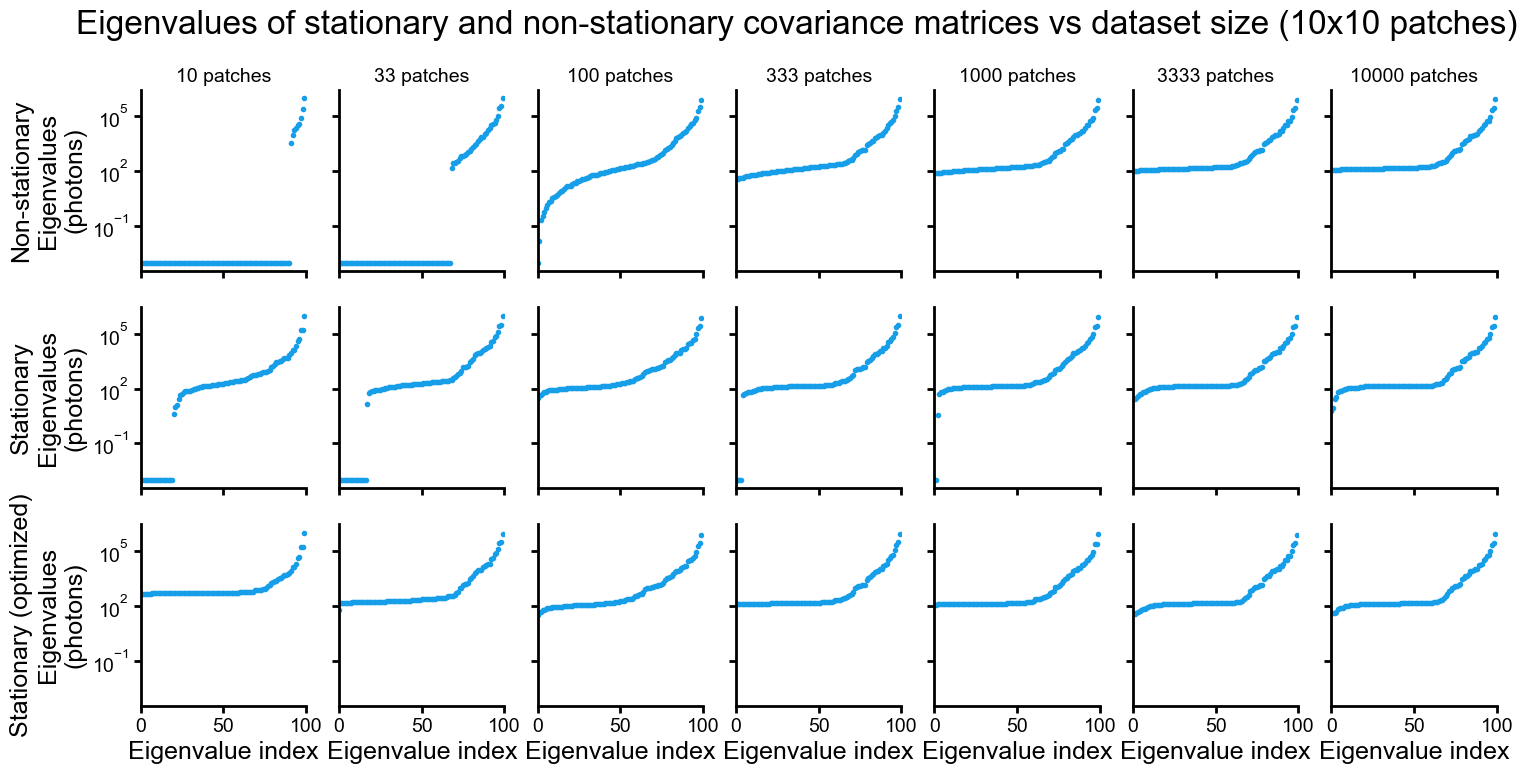

In [10]:
fig, ax = plt.subplots(3, num_patches_to_use.shape[0], figsize=(num_patches_to_use.shape[0] * 2.5, 8), sharex=True, sharey=True)

for i, n_patches in enumerate(num_patches_to_use):
    eigs = np.linalg.eigvalsh(cov_mats[n_patches][0])
    eigs_stationary = np.linalg.eigvalsh(cov_mats_stationary[n_patches][0])
    eigs_stationary_optimized = np.linalg.eigvalsh(cov_mats_stationary_optimized[n_patches][0])
    ax[0, i].semilogy(eigs, '.')
    ax[1, i].semilogy(eigs_stationary, '.')
    ax[2, i].semilogy(eigs_stationary_optimized, '.')
    clear_spines(ax[0, i])
    clear_spines(ax[1, i])
    clear_spines(ax[2, i])
    

    ax[0, i].set_title(f'{n_patches} patches')
    if i == 0:
        ax[0, i].set_ylabel('Non-stationary\nEigenvalues\n(photons)')
        ax[1, i].set_ylabel('Stationary\nEigenvalues\n(photons)')
        ax[2, i].set_ylabel('Stationary (optimized)\nEigenvalues\n(photons)')
    ax[-1, i].set(xlabel='Eigenvalue index', xlim=[0, len(eigs)])


fig.suptitle('Eigenvalues of stationary and non-stationary covariance matrices vs dataset size ({}x{} patches)'.format(patch_size, patch_size))